In [ ]:
!pip install spkit
!pip install wfdb
!pip install neurokit2
!pip install tf_keras_vis

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import wfdb
import neurokit2 as nk
import spkit as sp

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers, models, regularizers
from sklearn.model_selection import train_test_split



# Load all data
create lists to store the signals, p and r wave annotations 

In [3]:
# get the data 
record_names = wfdb.get_record_list('but-pdb')
database = 'but-pdb'

#store data from different records
signals = []
p_anns = []
r_anns = []
samp_freq = []

for i, rec in enumerate(record_names):
    #load record
    record = wfdb.rdrecord(f"{int(rec):02}", pn_dir = database)
    if record.fs != 360:
        continue
    if i == 35:
        break
    

    #load signal and annotations
    sig = record.p_signal[:,0]
    p_ann = wfdb.rdann(f"{int(rec):02}", 'pwave', pn_dir=database)
    if len(p_ann.sample) < 10:
        continue
    r_ann = wfdb.rdann(f"{int(rec):02}", 'qrs', pn_dir = database)

    print(f"Record being collected is record number: {int(rec):02}")
    #store signals and annotations
    signals.append(sig)
    p_anns.append(p_ann)
    r_anns.append(r_ann)
    samp_freq.append(record.fs)

Record being collected is record number: 01
Record being collected is record number: 02
Record being collected is record number: 03
Record being collected is record number: 04
Record being collected is record number: 05
Record being collected is record number: 06
Record being collected is record number: 07
Record being collected is record number: 09
Record being collected is record number: 10
Record being collected is record number: 11
Record being collected is record number: 12
Record being collected is record number: 13
Record being collected is record number: 14
Record being collected is record number: 15
Record being collected is record number: 16
Record being collected is record number: 17
Record being collected is record number: 18
Record being collected is record number: 19
Record being collected is record number: 20
Record being collected is record number: 21
Record being collected is record number: 22
Record being collected is record number: 23
Record being collected is record

# Plot signals

to see accuracy of the signals and annotation, plot the signals and the p peak annotation

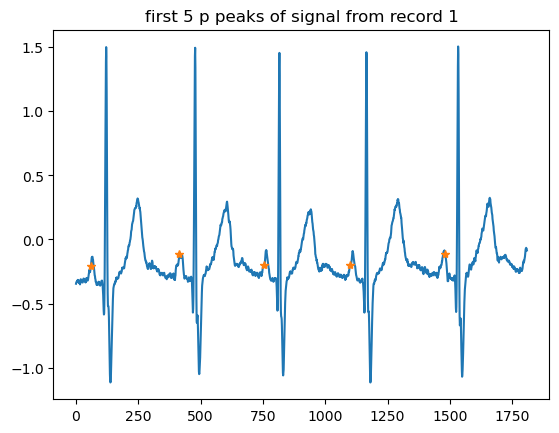

0 is complete


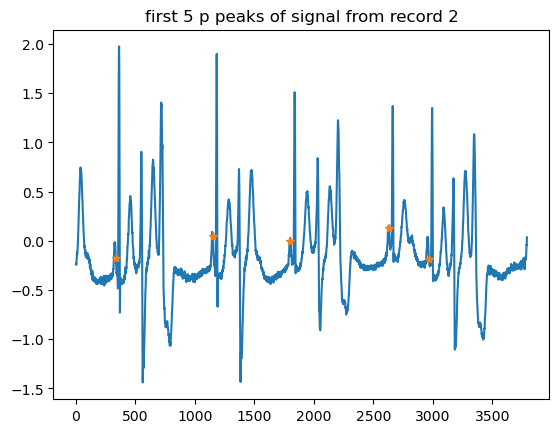

1 is complete


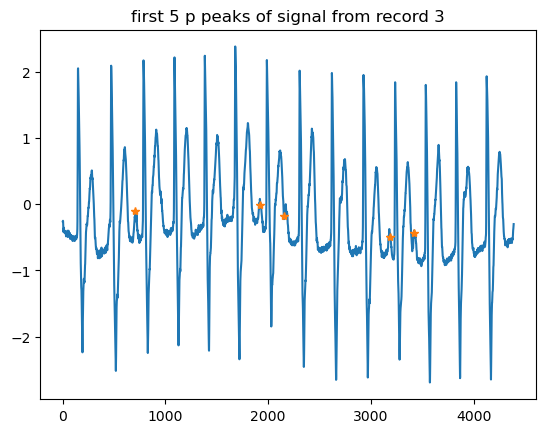

2 is complete


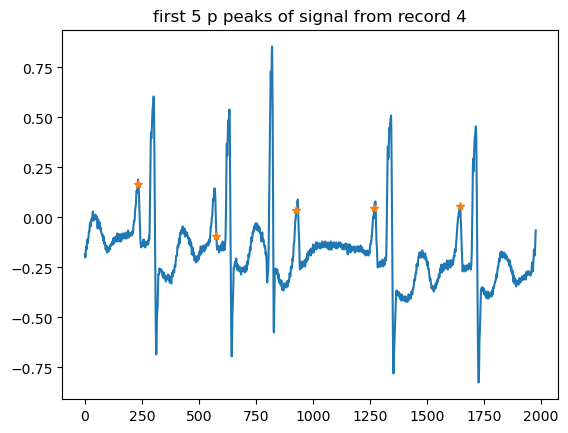

3 is complete


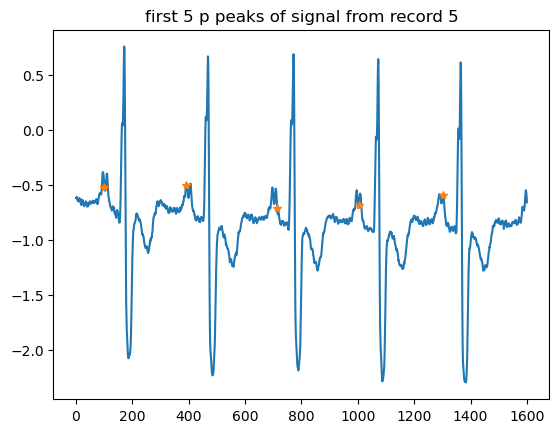

4 is complete


In [4]:
#plot signal and P peaks
for i in range(5):
    plt.title(f'first 5 p peaks of signal from record {i+1}')
    plt.plot(signals[i][:p_anns[i].sample[5]])
    plt.plot(p_anns[i].sample[:5],signals[i][p_anns[i].sample[:5]],'*')
    plt.show()
    print(f'{i} is complete')

# Clean the signals up

to have a more smooth transition and remove a lot of small movements

/opt/conda/lib/python3.11/site-packages/scipy/signal/_filter_design.py:2914: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)


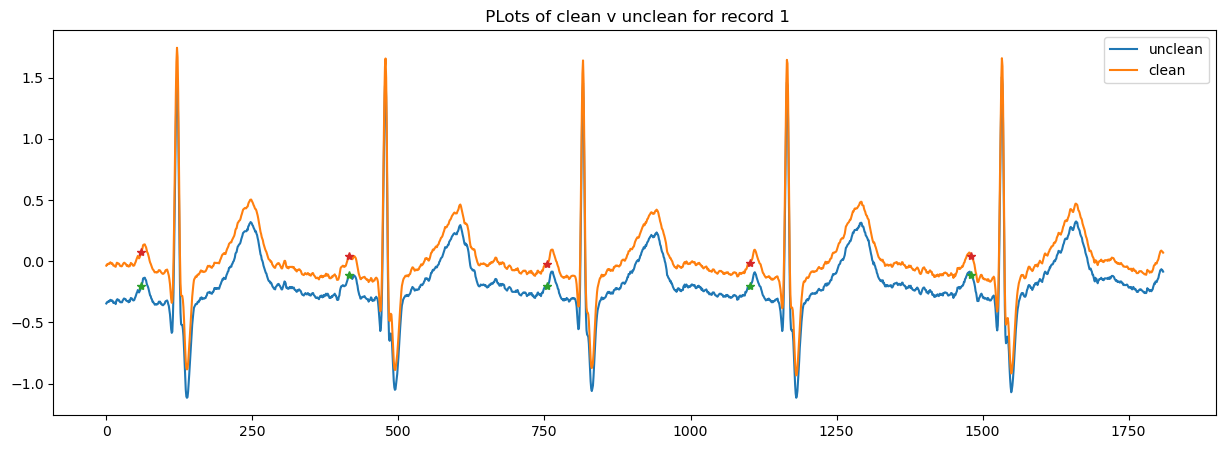

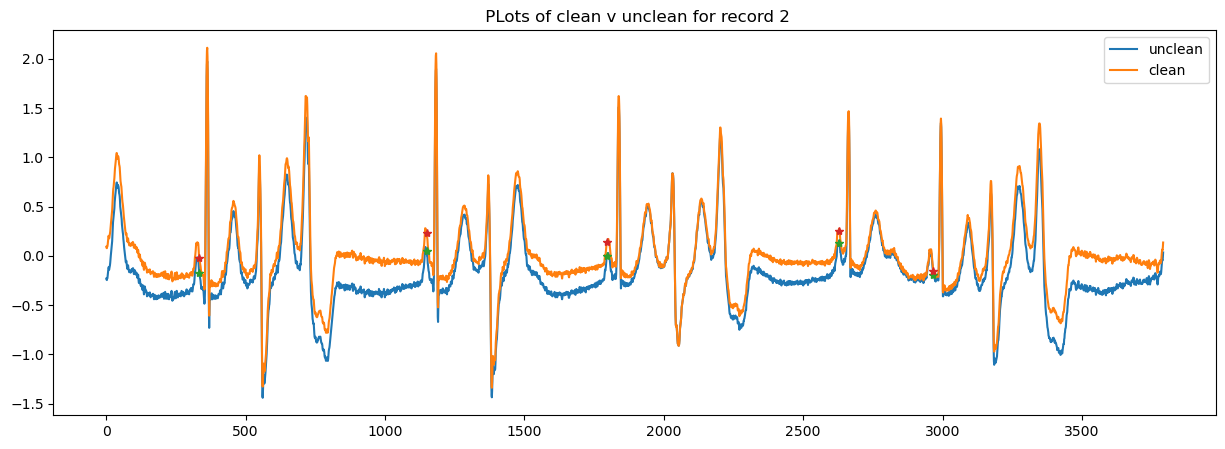

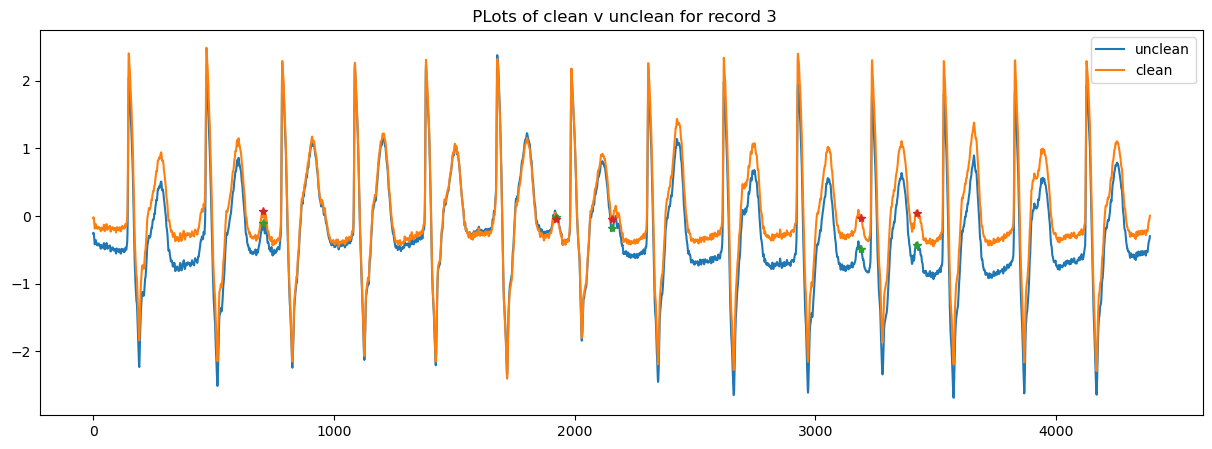

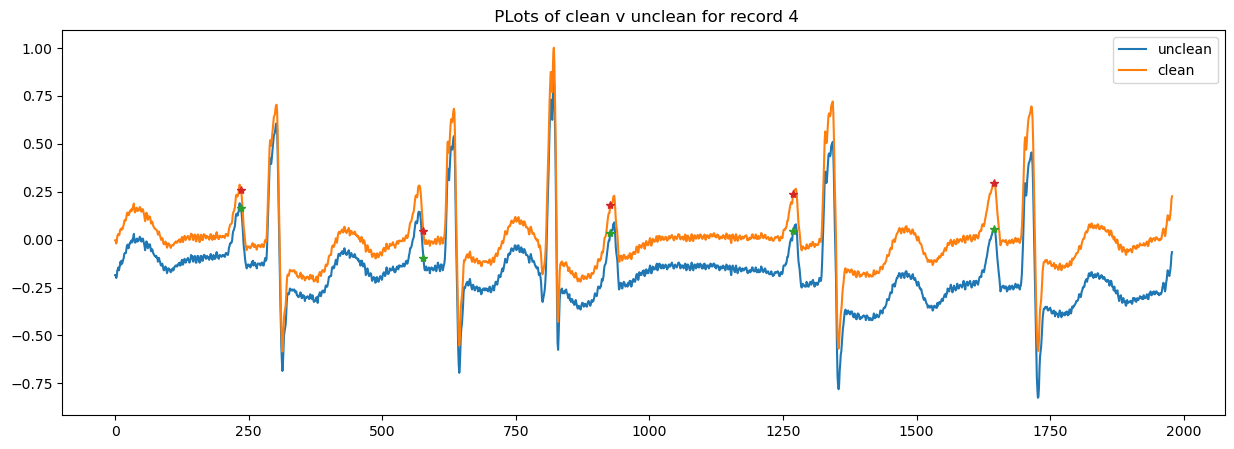

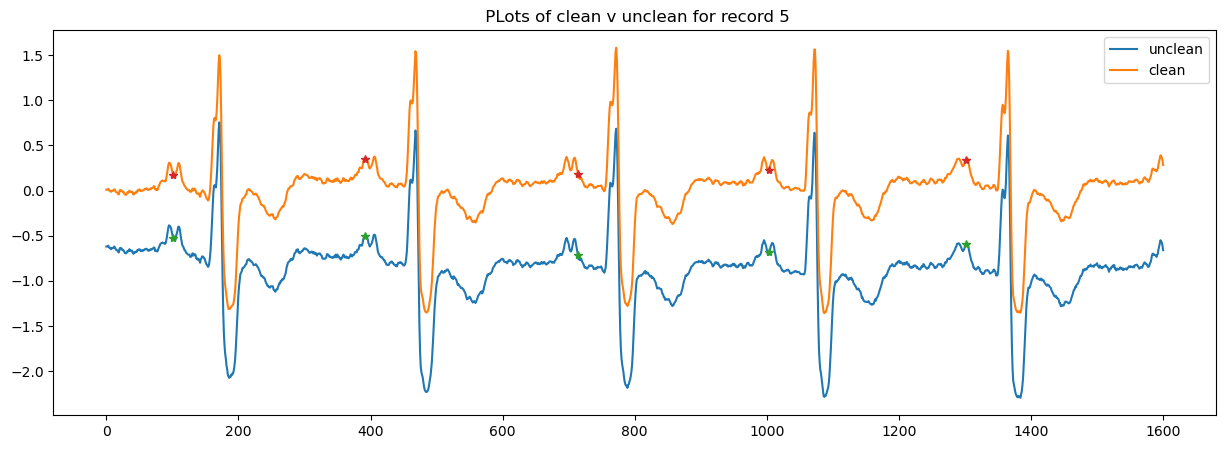

In [5]:
# clean the signals
def cleanTheSignals(signals):
    clean_signals = []
    
    for i in range(len(signals)):
        sig_clean = signals[i].copy()
        sig_clean = sp.filter_X(sig_clean,360,band=[0.5], btype='highpass',ftype='SOS')
        sig_clean = sp.filter_X(sig_clean,360,band=[150], btype='lowpass',ftype='SOS')
    
        clean_signals.append(sig_clean)

    return clean_signals

clean_signals = cleanTheSignals(signals)

for i in range(5):
    #plot signals against each other
    plt.figure(figsize = (15,5))
    plt.title(f' PLots of clean v unclean for record {i+1}')
    
    plt.plot(signals[i][:p_anns[i].sample[5]], label = 'unclean')
    plt.plot(clean_signals[i][:p_anns[i].sample[5]], label = 'clean')
    
    plt.plot(p_anns[i].sample[:5],signals[i][p_anns[i].sample[:5]],'*')
    plt.plot(p_anns[i].sample[:5],clean_signals[i][p_anns[i].sample[:5]],'*')
    
    plt.legend()

# Plot accuracy of P annotions

The P peak annotation does not seem that accurate, print out p peaks from one signal to see the accuracy of the p peak

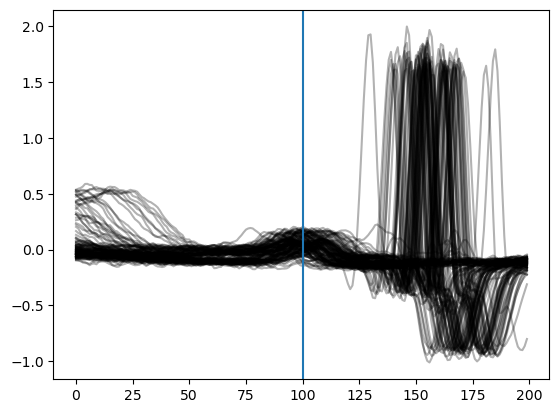

In [6]:
for i in range(len(p_anns[0].sample)):
  plt.plot(clean_signals[0][p_anns[0].sample[i] - 100 : p_anns[0].sample[i] +100], color = 'k', alpha = 0.3)
plt.axvline(100)

# Use algorithm to find p peak

The plot shows the peak are not centered around 30 ( where we made the peak to be), which means the annotations are not that accurate. We will now split with neurokit and compare the accuracy

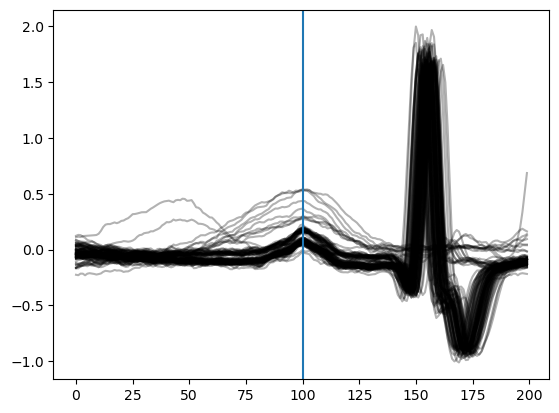

In [7]:
_, rpeaks = nk.ecg_peaks(clean_signals[0], sampling_rate=360)
rpks = rpeaks['ECG_R_Peaks']

# Delineate the ECG signal
_, waves_peak = nk.ecg_delineate(clean_signals[0], rpks, sampling_rate=360, method="peak")

pws = waves_peak['ECG_P_Peaks']

for i in range(len(pws)):
    if pws[i] not in [np.nan]:
        plt.plot(clean_signals[0][pws[i] - 100 : pws[i] +100], color = 'k', alpha = 0.3)
plt.axvline(100)

# use algorithm to convert all

after comparing results, the algorthm looks for better at odentifying the peak than the annotation, we will now overwrite P_anns and r_anns with the algortithms detection

In [8]:
len(r_anns)

34

In [9]:
def FindP_peaks(signals, fs):
    p_anns =[]
    r_anns= []
    
    for i in range(len(signals)):
        _, rpeaks = nk.ecg_peaks(signals[i], sampling_rate=fs)
        rpks = rpeaks['ECG_R_Peaks']
        
        # Delineate the ECG signal
        _, waves_peak = nk.ecg_delineate(signals[i], rpks, sampling_rate=fs, method="peak")
        
        pws = waves_peak['ECG_P_Peaks']
    
        p_anns.append(pws)
        r_anns.append(rpks)

    return p_anns, r_anns

p_anns, r_anns = FindP_peaks(clean_signals, 360)

# split the signals in to singular beats

In [10]:
# split into beats
def SplitBeats(p_anns, r_anns, signals):
    #remove all nans
    for i in range(len(p_anns)):
        arr = np.array(p_anns[i])
        cleaned_arr = arr[~np.isnan(arr)] 
        p_anns[i] = cleaned_arr.astype(int).tolist()
        
    beats = []
    p_pks = []
    r_pks = []
    
    for i in range(len(signals)):
        rpks = np.array(r_anns[i], dtype=int)
        ppks = np.array(p_anns[i], dtype=int)
    
        
        #create split lines
        boundaries = np.zeros(len(rpks) + 1, dtype=int)
        for k in range(1, len(rpks)):
            boundaries[k] = (rpks[k - 1] + rpks[k]) // 2
    
        if (p for p in ppks if boundaries[j] <= p < boundaries[j+1]) in [np.nan]:
            print(f' tru and p is {p}')
    
    
       # split the beats and re align p and r peak
        for j in range(len(rpks)):
            beat = signals[i][boundaries[j]: boundaries[j+1]]
            beat = beat - np.mean(beat)
    
            #if there are no p peaks skip
            if len([p - boundaries[j] for p in ppks if boundaries[j] <= p < boundaries[j+1]]) == 0:
                continue
                
            beats.append(beat)
            r_pks.append(rpks[j] - boundaries[j])
            p_pks.append([p - boundaries[j] for p in ppks if boundaries[j] <= p < boundaries[j+1]])

    return beats, p_pks, r_pks

beats, p_pks, r_pks = SplitBeats(p_anns, r_anns, clean_signals)

/opt/conda/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
/opt/conda/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide


In [11]:
len(r_pks)

4617

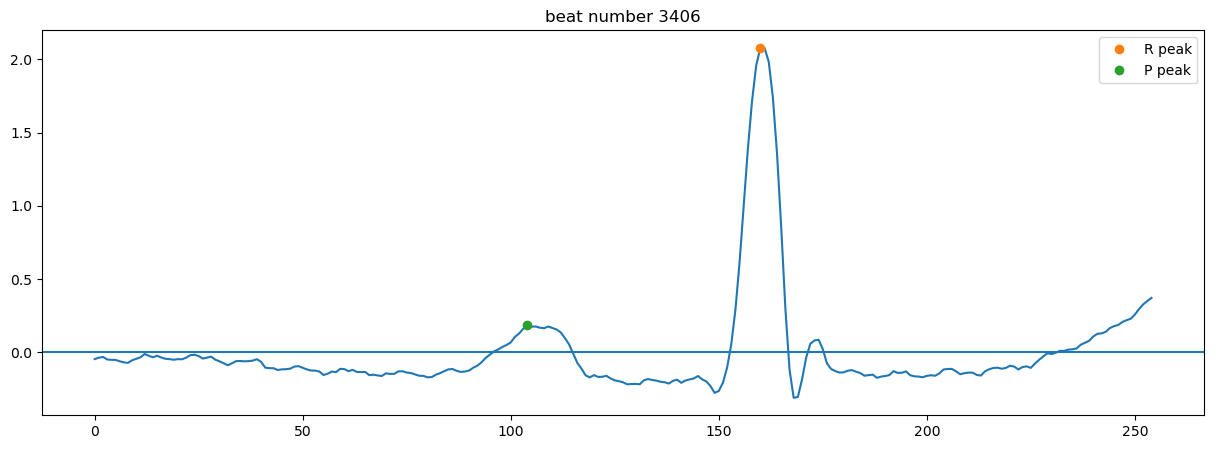

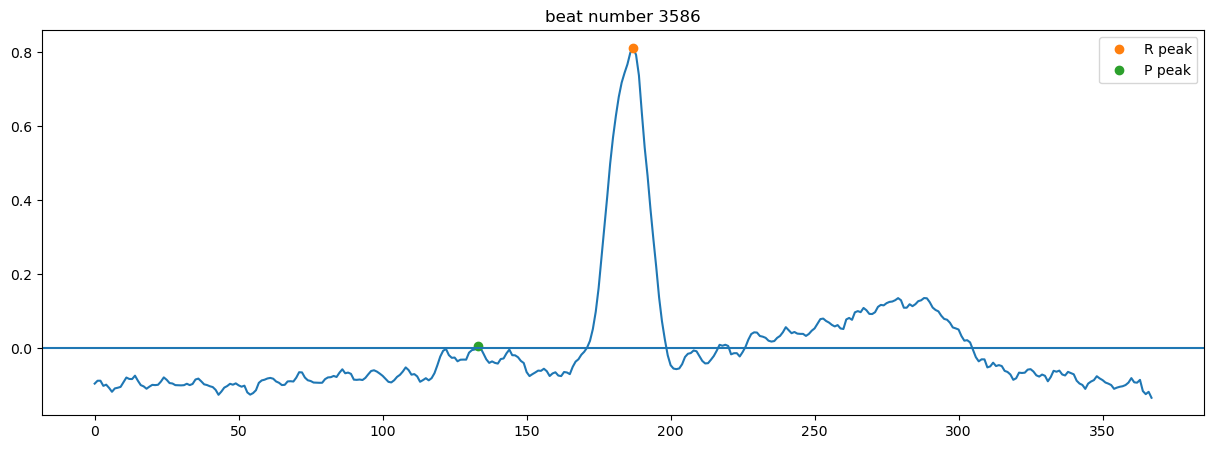

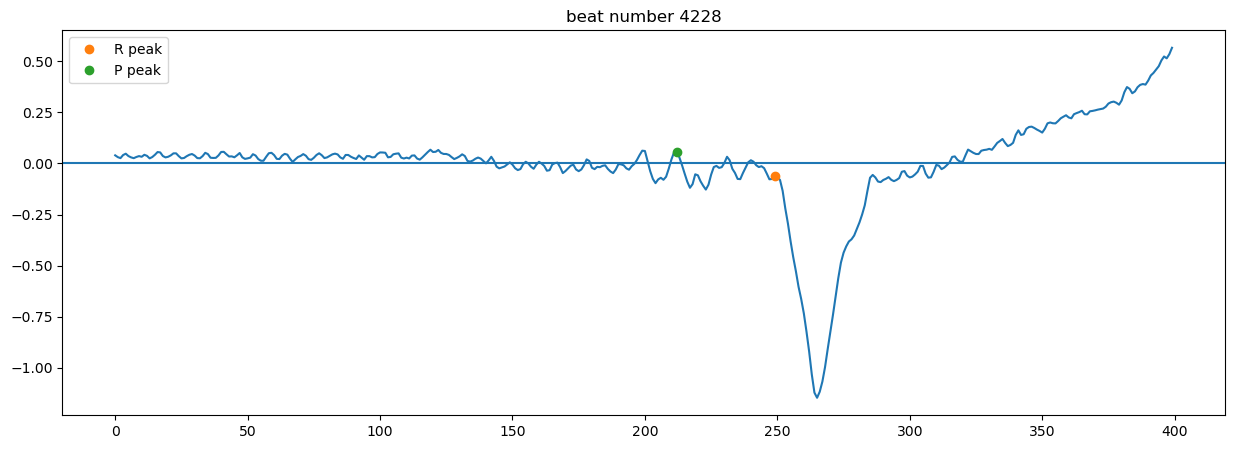

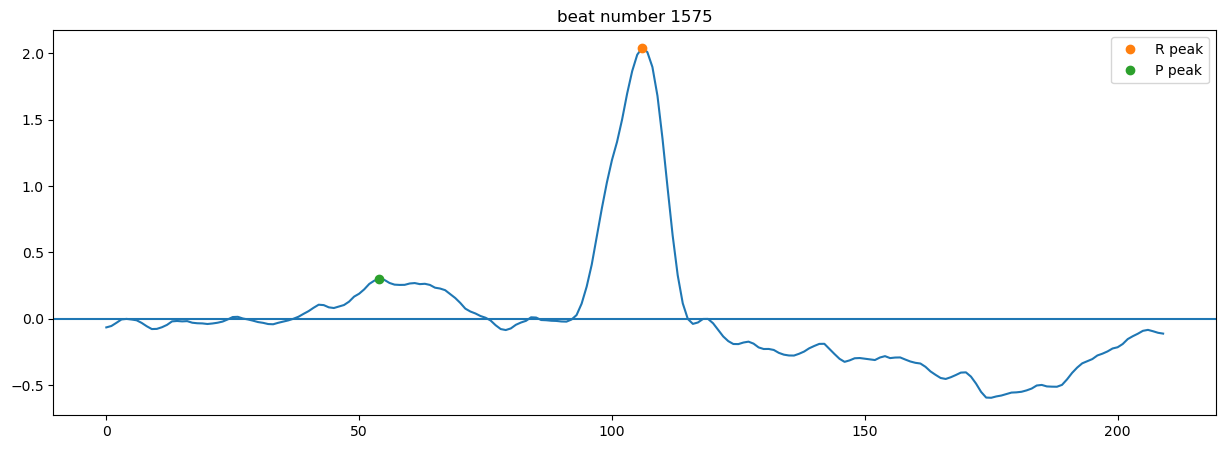

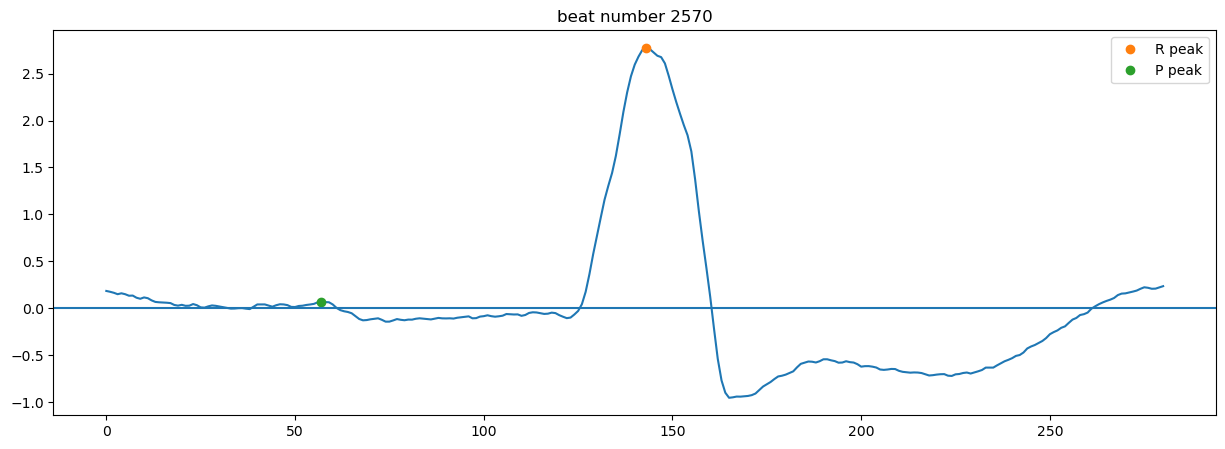

In [12]:
#print 5 random beats

rand_beat = np.random.randint(1, 5000, size=5)

for i in rand_beat:
    plt.figure(figsize=(15, 5))
    plt.plot(beats[i])
    plt.plot(r_pks[i], beats[i][r_pks[i]], 'o', label='R peak')
    plt.plot(p_pks[i], beats[i][p_pks[i]], 'o', label='P peak')
    plt.title(f'beat number {i}')
    plt.axhline(0)
    plt.legend()

# split into X and y train

In [13]:
# split into X and y 

X = beats.copy()
y =[]

for i, p in enumerate(p_pks):
    if len(p) > 0:
        #take only the first p peak
        y.append(beats[i][p[0]])
    else:
        y.append(0.0)

In [14]:
# pad X values as they are different sizes
max_len = max(len(x) for x in X)
X = pad_sequences(
    X, maxlen=max_len, dtype="float32",
    padding="post", value=0.000
)[..., np.newaxis]   
y = np.array(y, dtype="float32")

In [15]:
indices = np.arange(len(p_pks))
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(X, y, indices, test_size=0.2, random_state=42)
beats_ppks_train = [p_pks[i] for i in idx_train]
beats_ppks_test  = [p_pks[i] for i in idx_test]

# build the model NOT USING THIS ONE

In [ ]:
inp = layers.Input(shape=(None, 1)) 

mask = tf.cast(tf.not_equal(inp, 0.0), tf.float32)

x = layers.Conv1D(64, 5,  padding="same", activation="relu", kernel_regularizer=regularizers.l2(1e-5))(inp)
x = layers.Dropout(0.1)(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling1D(pool_size=2, padding="same")(x)
mask = layers.MaxPooling1D(pool_size=2, padding="same")(mask)

x = layers.Conv1D(64, 5, padding="same", activation="relu", kernel_regularizer=regularizers.l2(1e-6))(x)
x = layers.Dropout(0.1)(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling1D(pool_size=2, padding="same")(x)
mask = layers.MaxPooling1D(pool_size=2, padding="same")(mask)

x = layers.Conv1D(128, 5,strides = 2, padding="same", activation="relu", kernel_regularizer=regularizers.l2(1e-7))(x)
mask = layers.MaxPool1D(pool_size=2, strides = 2, padding= "same")(mask)
x = layers.Dropout(0.2)(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling1D(pool_size=2, padding="same")(x)
mask = layers.MaxPooling1D(pool_size=2, padding="same")(mask)


x = layers.Conv1D(256, 5, strides = 2, padding="same", activation="relu", kernel_regularizer=regularizers.l2(1e-8))(x)
mask = layers.MaxPool1D(pool_size=2, strides = 2, padding= "same")(mask)
x = layers.Dropout(0.3)(x)
x = layers.BatchNormalization()(x)

# Apply mask: zero-out any features at paddings
x = x * mask

# masked global average
sum_feats  = tf.reduce_sum(x, axis=1)      
count_real = tf.reduce_sum(mask, axis=1)    
avg_feats  = sum_feats / tf.maximum(count_real, 1.0)


x = layers.Dense(64, activation="relu", kernel_regularizer=regularizers.l2(1e-4))(x)
x = layers.Dropout(0.2)(x)

out = layers.Dense(1, activation="linear", kernel_regularizer=regularizers.l2(1e-4))(avg_feats)

model = models.Model(inputs=inp, outputs=out)
model.compile(optimizer="adam", loss="mse", metrics=["mae"])


lr_sched = tf.keras.callbacks.ReduceLROnPlateau(
  monitor="val_mae", factor=0.5, patience=2
)
# model.summary()
history = model.fit(X_train, y_train, batch_size=32, epochs=25, validation_split=0.3, callbacks = [ lr_sched])

# CNN with max pool and strides

In [121]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers

# 1) Inputs & mask
inp  = layers.Input(shape=(None, 1))
mask = tf.cast(tf.not_equal(inp, 0.0), tf.float32)  # shape=(batch, T, 1)
x    = inp

# 2) Conv‐pool blocks
# Block 0
x    = layers.Conv1D(64, 5, strides=2, padding="same", activation="relu", kernel_regularizer=regularizers.l2(1e-5))(x)
mask = layers.MaxPooling1D(pool_size=2, strides=2, padding="same")(mask)
x    = layers.Dropout(0.1)(x)
x    = layers.BatchNormalization()(x)
x    = layers.MaxPooling1D(pool_size=2, padding="same")(x)
mask = layers.MaxPooling1D(pool_size=2, padding="same")(mask)

# Block 1
x    = layers.Conv1D(128, 5, strides=2, padding="same", activation="relu", kernel_regularizer=regularizers.l2(1e-6))(x)
mask = layers.MaxPooling1D(pool_size=2, strides=2, padding="same")(mask)
x    = layers.Dropout(0.2)(x)
x    = layers.BatchNormalization()(x)
x    = layers.MaxPooling1D(pool_size=2, padding="same")(x)
mask = layers.MaxPooling1D(pool_size=2, padding="same")(mask)

# Block 2
x    = layers.Conv1D(256, 5, strides=1, padding="same", activation="relu", kernel_regularizer=regularizers.l2(1e-7))(x)
x    = layers.Dropout(0.3)(x)
x    = layers.BatchNormalization()(x)
x    = layers.MaxPooling1D(pool_size=2, padding="same")(x)
mask = layers.MaxPooling1D(pool_size=2, padding="same")(mask)

# 3) Apply mask
x = layers.Multiply()([x, mask])

# 4) Global pooling + head
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(1e-4))(x)
x = layers.Dropout(0.3)(x)
out = layers.Dense(1, activation="linear")(x)

# 5) Build & compile
model = models.Model(inputs=inp, outputs=out)
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="mse",
    metrics=["mae"]
)

# Inspect
model.summary()

# example training setup
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_mae", factor=0.5, patience=3, min_lr=1e-6),
    # tf.keras.callbacks.EarlyStopping(monitor="val_mae", patience=6, restore_best_weights=True)
]

history = model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=50,
    validation_split=0.2,
    callbacks=callbacks
)


Model: "model_31"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, None, 1)]            0         []                            
                                                                                                  
 conv1d_3 (Conv1D)           (None, None, 64)             384       ['input_2[0][0]']             
                                                                                                  
 dropout_4 (Dropout)         (None, None, 64)             0         ['conv1d_3[0][0]']            
                                                                                                  
 batch_normalization_3 (Bat  (None, None, 64)             256       ['dropout_4[0][0]']           
 chNormalization)                                                                          

In [126]:
model.save_weights('ecg_regression_trained.h5')

In [176]:
import json
hist_py = { k: [float(x) for x in v] for k, v in history.history.items() }

with open('training_history.json', 'w') as f:
    json.dump(hist_py, f)

# Plots

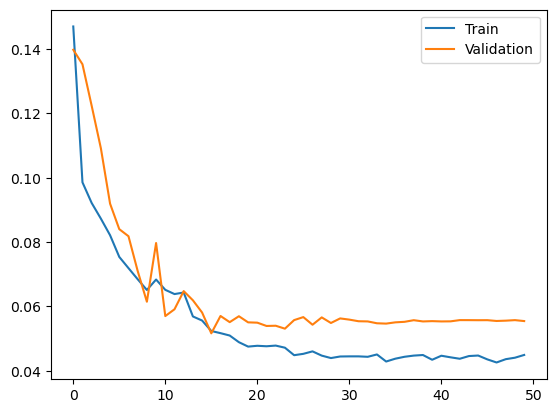

In [17]:
plt.plot(history.history['mae'], label = 'Train')
plt.plot(history.history['val_mae'], label = 'Validation')
plt.legend()


In [18]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
y_pred = model.predict(X_test)
print("MAE:", mean_absolute_error(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))
print("R2: ", r2_score(y_test, y_pred))


29/29 [==============================] - 0s 7ms/step
MAE: 0.05362727865576744
MSE: 0.007817934267222881
R2:  0.7249554395675659


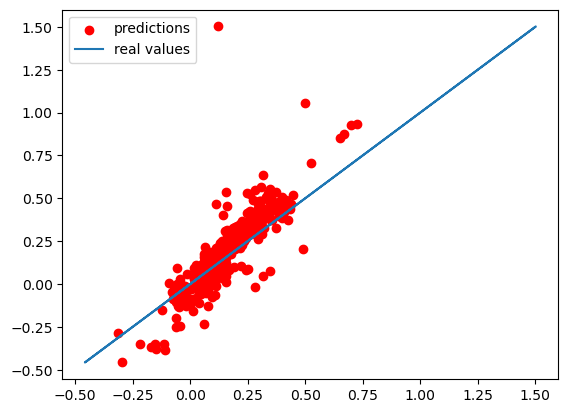

In [19]:
plt.scatter(y_pred, y_test, color = 'red', label = 'predictions')
plt.plot(y_test, y_test, label = 'real values')
plt.legend()

# Load saliency records

Now that we have trained the model and tested it using the train and test sets, for the saliency maps I will use 2 different records that were not part of train and test sets to view saliency maps. this is to see how accurate the model is on completely unseen data and when plotting averages and means of saliency maps, we have a clearer image

In [97]:
signals_sal = []
p_anns_sal = []
r_anns_sal = []

for rec in ['36', '37']:
    record =  wfdb.rdrecord(rec, pn_dir = database)
    
    sig = record.p_signal[:,0]
    p_ann = wfdb.rdann(f"{int(rec):02}", 'pwave', pn_dir=database)
    if len(p_ann.sample) < 10:
        continue
    r_ann = wfdb.rdann(f"{int(rec):02}", 'qrs', pn_dir = database)

    print(f"Record being collected is record number: {int(rec):02}")
    #store signals and annotations
    signals_sal.append(sig)
    p_anns_sal.append(p_ann)
    r_anns_sal.append(r_ann)
    

Record being collected is record number: 36
Record being collected is record number: 37


In [98]:
signals_sal = cleanTheSignals(signals_sal)
p_anns_sal, r_anns_sal = FindP_peaks(signals_sal, 360)
beats_sal, p_pks_sal, r_pks_sal = SplitBeats(p_anns_sal, r_anns_sal, signals_sal)

/opt/conda/lib/python3.11/site-packages/scipy/signal/_filter_design.py:2914: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
/opt/conda/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
/opt/conda/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide


In [99]:
labels_sal = []

for i, p in enumerate(p_pks_sal):
    if len(p) > 0:
        #take only the first p peak
        labels_sal.append(beats_sal[i][p[0]])
    else:
        labels_sal.append(0.0)



In [100]:
len(beats_sal) == len(r_pks_sal) == len(p_pks_sal) ==len(labels_sal)

True

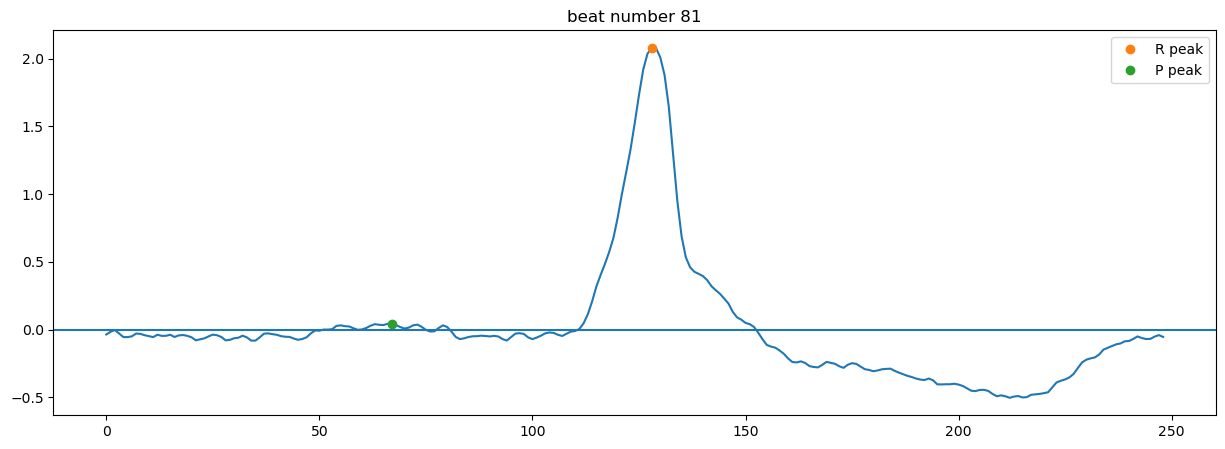

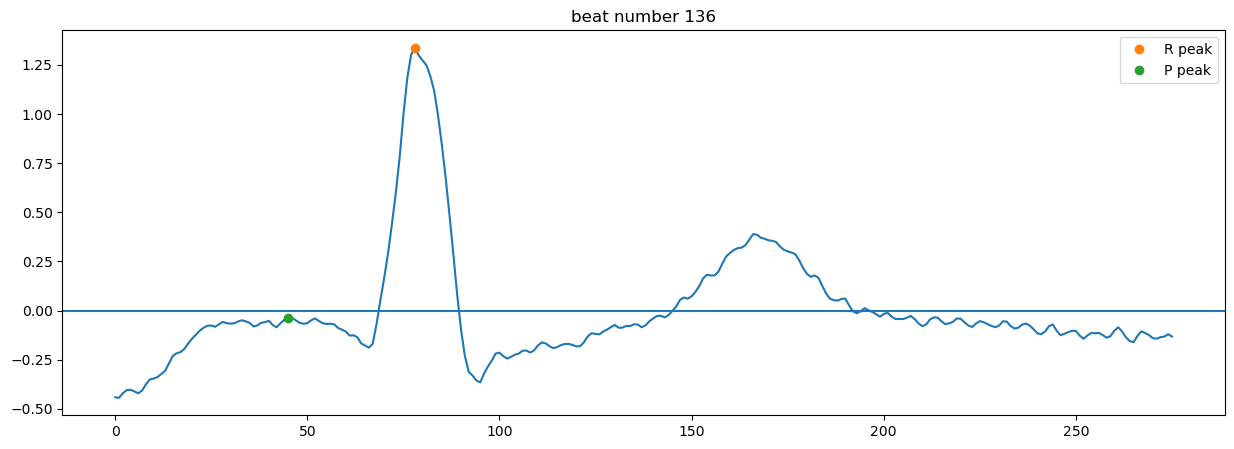

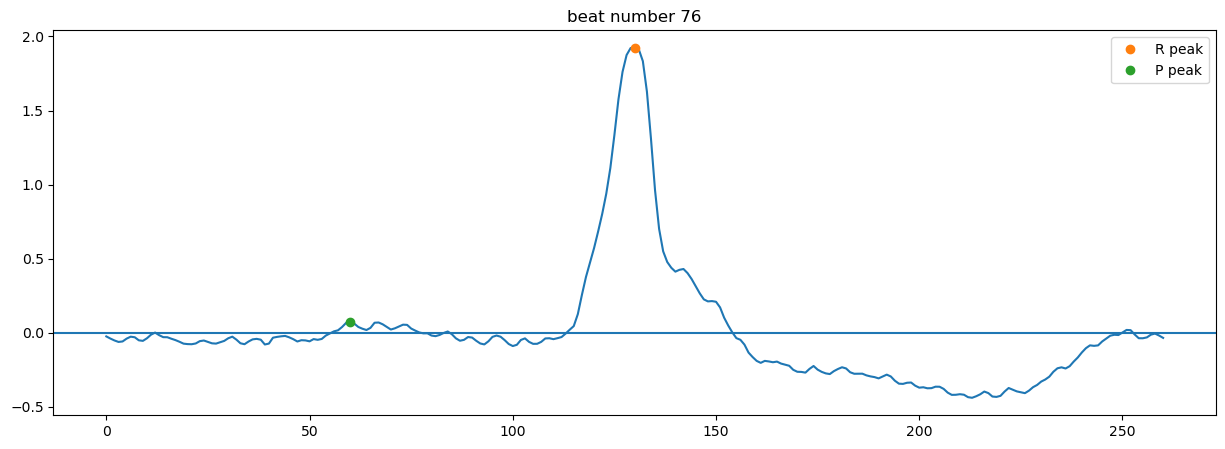

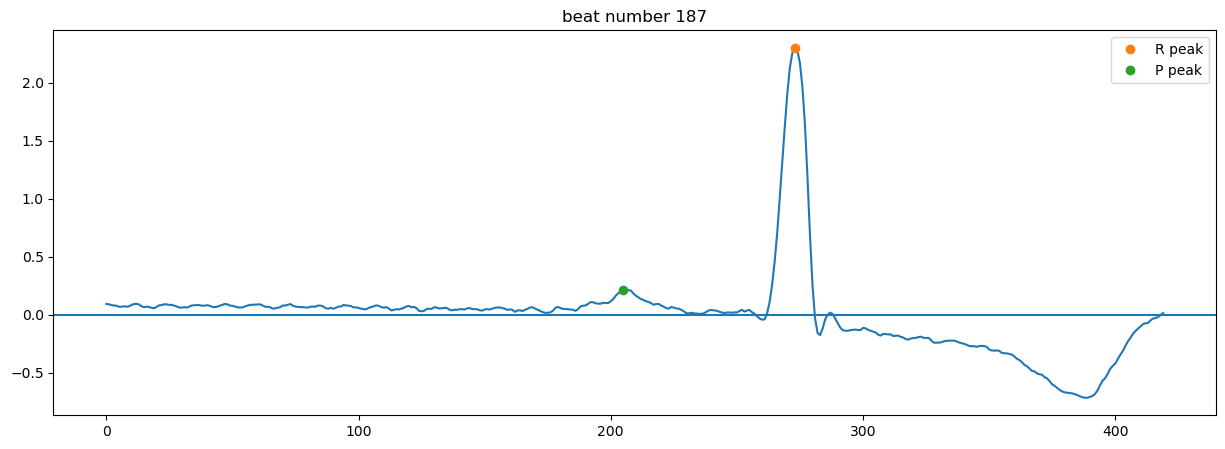

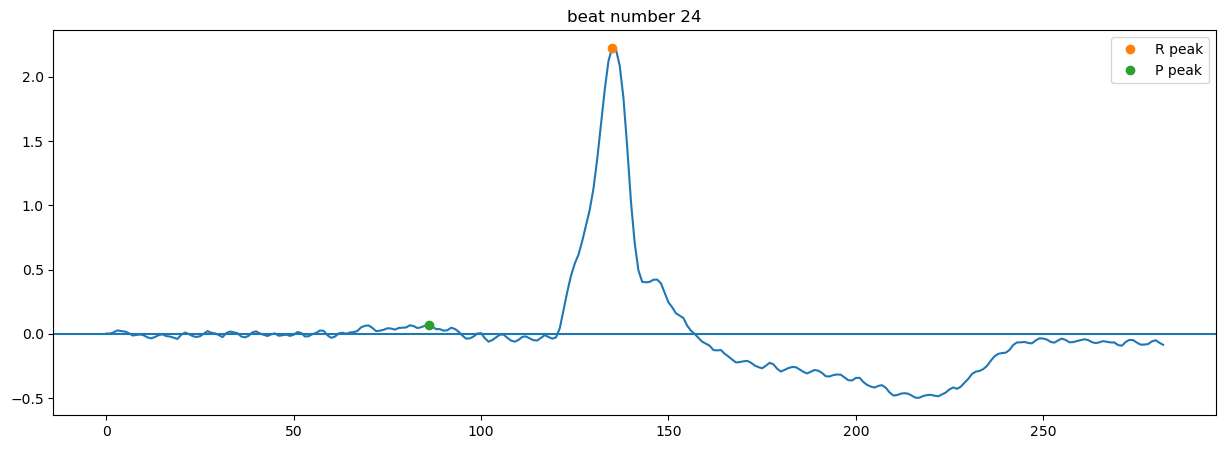

In [101]:
#print 5 random beats

rand_beat = np.random.randint(1, 241, size=5)

for i in rand_beat:
    plt.figure(figsize=(15, 5))
    plt.plot(beats_sal[i])
    plt.plot(r_pks_sal[i], beats_sal[i][r_pks_sal[i]], 'o', label='R peak')
    plt.plot(p_pks_sal[i], beats_sal[i][p_pks_sal[i]], 'o', label='P peak')
    plt.title(f'beat number {i}')
    plt.axhline(0)
    plt.legend()

In [102]:
max_len = max(len(x) for x in beats_sal)
beats_sal = pad_sequences(
    beats_sal, maxlen=max_len, dtype="float32",
    padding="post", value=0.000
)[..., np.newaxis]   
labels_sal = np.array(labels_sal, dtype="float32")

# saliency maps IGNORE THIS SECTION

In [ ]:
#gradient based saliency
def saliency_fn(model, inp):
    #create mask like before, 1 where its non 0 and 0 when input is 0 (to ignore padding)
    mask = tf.cast(tf.not_equal(inp, 0.0), tf.float32)
    #record all gradients and pushes predictions
    with tf.GradientTape() as tape:
        tape.watch(inp)
        y_pred = model(inp)
    #calculates the gradients
    grads = tape.gradient(y_pred, inp)
    #multiply gradients with mask to remove padding and remove last dimension
    sal = tf.abs(grads*mask)
    sal = sal.numpy().squeeze(-1) 
    #normalize saliency between 0 and 1
    eps= 1e-8
    sal_norm = np.array([(m - m.min())/(m.max()-m.min()+eps) for m in sal])
    return sal_norm

In [ ]:
#integrated gradient functions function
#steps is number of integral approximation, more steps = higher accuracy
#baseline is reference input, 0s because that would be a flat ecg signal
def integrated_gradients(model, inp,steps=50):
    #conver ecg signals to tensors
    inp = tf.convert_to_tensor(inp, dtype=tf.float32)
    #create basline with the same shape as the ecg signal
    baseline = np.zeros_like(inp)
    baseline = tf.convert_to_tensor(baseline, dtype=tf.float32)

    #arrray of evenly spaced coefficients
    alphas = tf.linspace(0., 1., steps+1)
    #store gradients
    int_grads = []

    for n in range(inp.shape[0]):
        #get one signal
        single_inp = inp[n:n+1]
        single_base = baseline[n:n+1]

        #create weighted sums between basline and input and combine them
        interpolated_inputs = [single_base + alpha * (single_inp - single_base) for alpha in alphas]
        interpolated_inputs = tf.concat(interpolated_inputs, axis=0)

        #watches the inputs  and runs all inputs producing a prediction, essentially where the saliency happens
        with tf.GradientTape() as tape:
            tape.watch(interpolated_inputs)
            preds = model(interpolated_inputs)  
            out = tf.reduce_sum(preds)

        #computes the gradients 
        grads = tape.gradient(out, interpolated_inputs)  
        avg_grads = tf.reduce_mean(grads, axis=0)   # averages the gradients 
        int_grad = (single_inp - single_base) * avg_grads  # riehmann summ approximation
        int_grads.append(int_grad.numpy())

    #combine all samples into a one batch array
    int_grads = np.stack(int_grads, axis=0)  
    #remove last dimension
    ig_abs = np.abs(int_grads.squeeze(-1))
    #normalize saliency between 0 and 1
    eps = 1e-8
    ig_norm = np.array([(m - m.min())/(m.max()-m.min()+eps) for m in ig_abs])
    return ig_norm

In [ ]:
random_int = np.random.randint(0, 235)
samples = beats_sal[random_int:random_int+5]               
labels  = labels_sal[random_int:random_int+5]                 
peaks   = p_pks_sal [random_int:random_int+5]       

# compute saliency maps
sal_norm = saliency_fn(model, tf.convert_to_tensor(samples))
ig_norm = integrated_gradients(model, samples, steps=50)

preds = model.predict(samples).squeeze()

In [ ]:
for i in range(len(samples)):
    # extract one beat, and corresposning salinecy and p peak
    beat = samples[i].squeeze(-1)
    #saliency for vanilla and ig 
    smap_vanilla = sal_norm[i]
    smap_ig = ig_norm[i]
    #p peak
    pks = peaks[i]
    #sample length for x axis
    L = beat.shape[0]

    fig, axes = plt.subplots(1, 2, figsize=(18, 4), sharey=True)

    ax = axes[0]
    im0 = ax.imshow(np.vstack([smap_vanilla, smap_vanilla]), cmap='hot', aspect='auto', alpha=0.7,
                    extent=[0, L, beat.min(), beat.max()], origin='lower')
    ax.plot(np.arange(L), beat, color='black', linewidth=1.5, label='ECG Beat')
    ax.scatter(pks, beat[pks], c='cyan', edgecolors='k', s=80, label='P-Peak')
    ax.legend()
    ax.set_xlabel("Sample")
    ax.set_ylabel("Height")
    ax.set_title(f"Vanilla Saliency\nTrue peak: {labels[i]:.3f} - Pred: {preds[i]:.3f}")
    cbar = fig.colorbar(im0, ax=ax, pad=0.02)
    cbar.set_label("Saliency")

    ax = axes[1]
    im1 = ax.imshow(np.vstack([smap_ig, smap_ig]), cmap='hot', aspect='auto', alpha=0.7,
                    extent=[0, L, beat.min(), beat.max()], origin='lower')
    ax.plot(np.arange(L), beat, color='black', linewidth=1.5, label='ECG Beat')
    ax.scatter(pks, beat[pks], c='cyan', edgecolors='k', s=80, label='P-Peak')
    ax.legend()
    ax.set_xlabel("Sample")
    ax.set_title(f"Integrated Gradients\nTrue peak: {labels[i]:.3f} - Pred: {preds[i]:.3f}")

    cbar = fig.colorbar(im1, ax=ax, pad=0.02)
    cbar.set_label("Saliency")

# Library saliency maps

In [127]:
from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.scorecam import Scorecam
import scipy.ndimage
from tf_keras_vis.utils.model_modifiers import GuidedBackpropagation

In [178]:
def score(inputs):
    return model(inputs)

# def score(output):
#     return output[:, 0]  # If your output shape is (batch, 1)

random_int = np.random.randint(0, len(beats_sal), size = 5)
samples = np.stack([beats_sal[i] for i in random_int])
labels = np.stack([labels_sal[i] for i in random_int])
peaks = np.stack([p_pks_sal[i] for i in random_int])

preds = model.predict(samples).squeeze()



1/1 [==============================] - 0s 22ms/step


## vanilla saliency

In [129]:
# # # Create Saliency object.
van_saliency = Saliency(model, model_modifier=None, clone=True)
vanilla_saliency_map = van_saliency(score, samples)

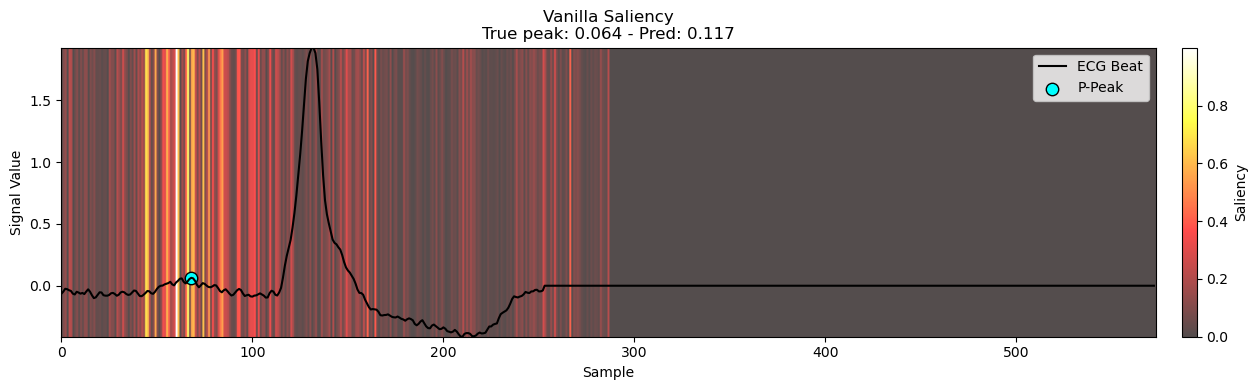

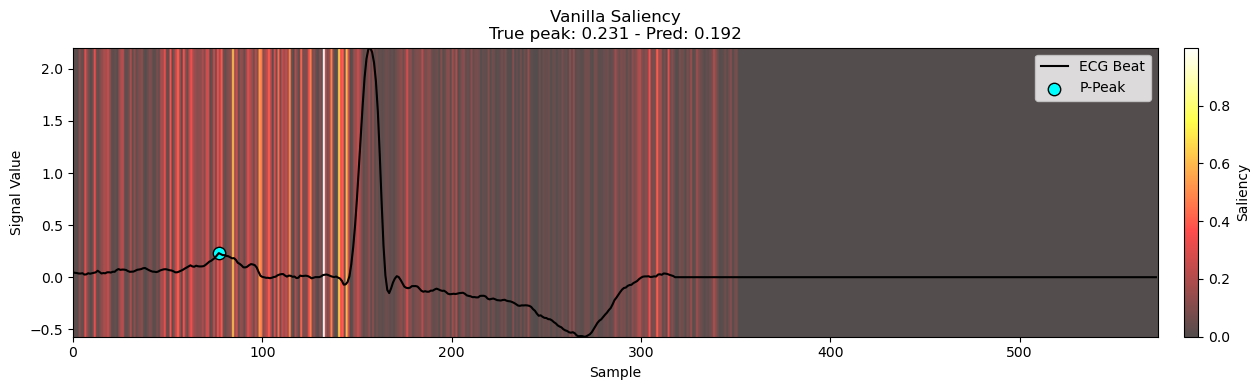

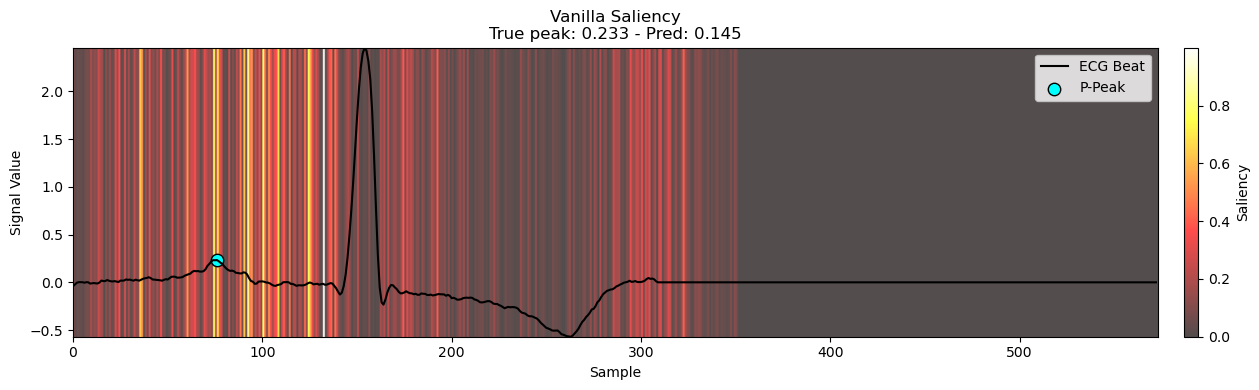

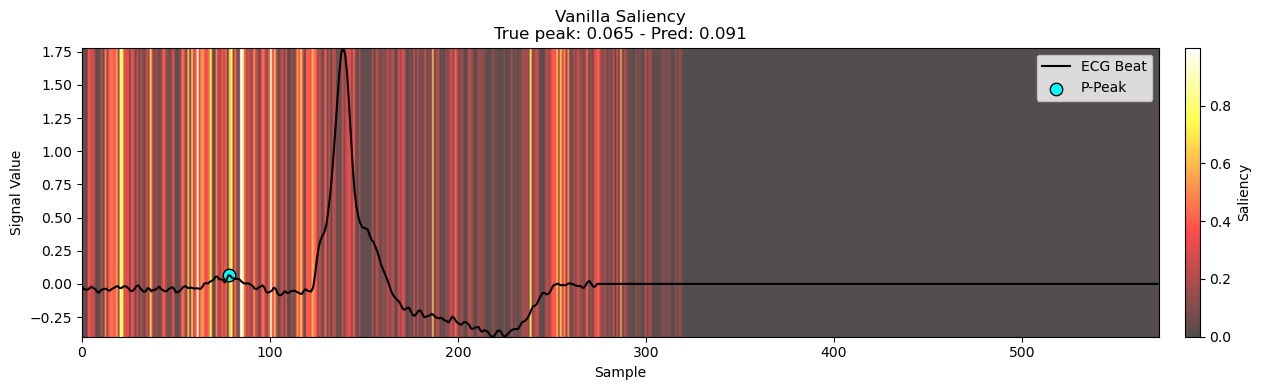

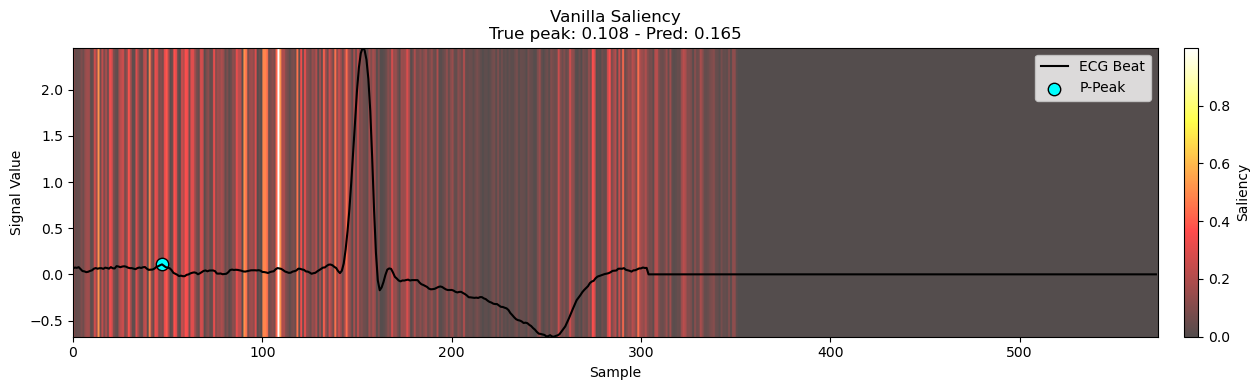

In [130]:
for i in range(len(samples)):
    beat = samples[i, :, 0]                    # ECG waveform
    smap_vanilla = vanilla_saliency_map[i]     # 1D saliency
    L = beat.shape[0]
    pks = peaks[i]                             # Indices of P-peaks for this beat
    label = labels[i]                          # True label
    pred = preds[i]                            # Predicted value

    fig, ax = plt.subplots(figsize=(14, 4))
    
    im0 = ax.imshow(
        np.vstack([smap_vanilla, smap_vanilla]), 
        cmap='hot', aspect='auto', alpha=0.7,
        extent=[0, L, beat.min(), beat.max()], origin='lower'
    )

    # Plot ECG waveform
    ax.plot(np.arange(L), beat, color='black', linewidth=1.5, label='ECG Beat')

    # Plot P-peaks
    ax.scatter(pks, beat[pks], c='cyan', edgecolors='k', s=80, label='P-Peak')

    ax.legend()
    ax.set_xlabel("Sample")
    ax.set_ylabel("Signal Value")
    ax.set_title(f"Vanilla Saliency\nTrue peak: {float(label):.3f} - Pred: {float(pred):.3f}")

    # Colorbar for the saliency
    cbar = fig.colorbar(im0, ax=ax, pad=0.02)
    cbar.set_label("Saliency")

    plt.tight_layout()
    plt.show()


/tmp/ipykernel_103/2598335758.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)


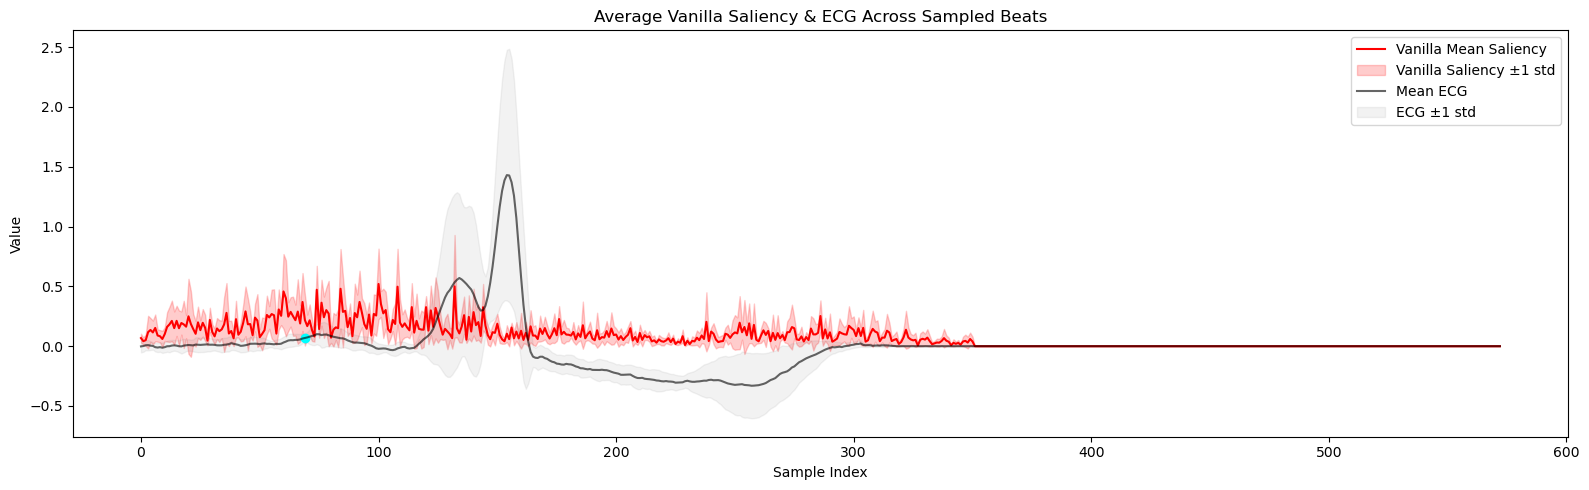

In [131]:
vanilla_mean_saliency = np.mean(vanilla_saliency_map, axis=0)
vanilla_std_saliency = np.std(vanilla_saliency_map, axis=0)

vanilla_mean_ecg = np.mean(samples[:, :, 0], axis=0)
vanilla_std_ecg = np.std(samples[:, :, 0], axis=0)

vanilla_mean_peaks = np.mean(peaks[:], axis = 0)

x = np.arange(vanilla_mean_saliency.shape[0])

plt.figure(figsize=(16, 5))
plt.plot(x, vanilla_mean_saliency, color='red', label='Vanilla Mean Saliency')
plt.fill_between(x,vanilla_mean_saliency - vanilla_std_saliency,vanilla_mean_saliency + vanilla_std_saliency,color='red', alpha=0.2, label='Vanilla Saliency ±1 std')

plt.plot(x, vanilla_mean_ecg, color='black', label='Mean ECG', alpha=0.6)
plt.fill_between(x, vanilla_mean_ecg - vanilla_std_ecg, vanilla_mean_ecg + vanilla_std_ecg,color='gray', alpha=0.1, label='ECG ±1 std')


plt.scatter(vanilla_mean_peaks, vanilla_mean_ecg[int(vanilla_mean_peaks)], color = 'cyan')

plt.title('Average Vanilla Saliency & ECG Across Sampled Beats')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.legend()
plt.tight_layout()
plt.show()


## sg

In [132]:
# Generate saliency map with smoothing that reduce noise by adding noise
sg_saliency = Saliency(model, model_modifier=None, clone=True)
sg_saliency_map = sg_saliency(
    score,
    samples,
    smooth_samples=20,  # The number of calculating gradients iterations.
    smooth_noise=0.20)  # noise spread level.

# After computing sg_saliency_map
mask_np = (samples != 0).astype(np.float32)  # 1 where real data, 0 where padding
mask_np = np.squeeze(mask_np, axis=-1)       # Remove channel dimension if present

sg_saliency_map = np.copy(sg_saliency_map)
sg_saliency_map[mask_np == 0] = 0

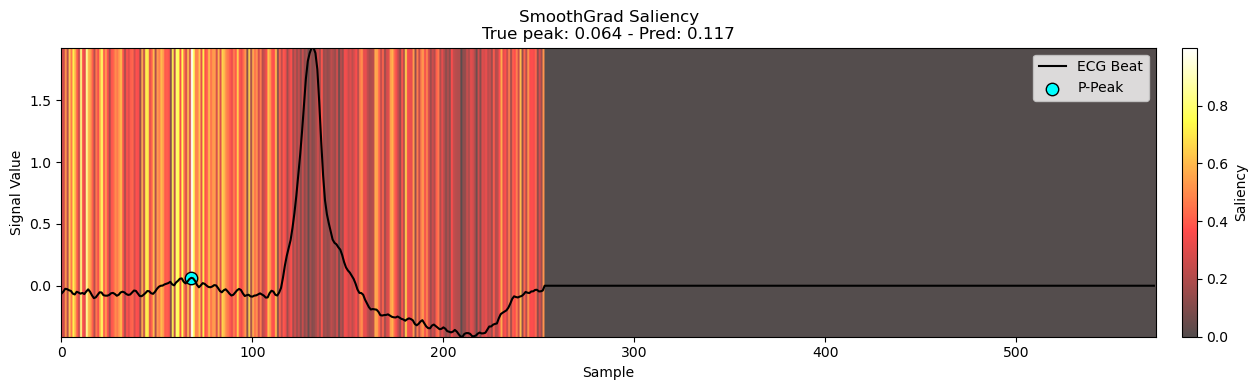

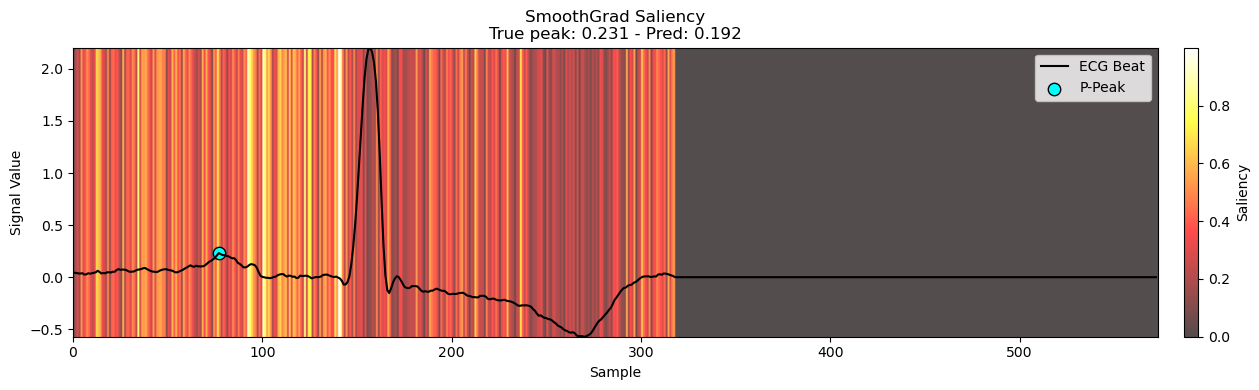

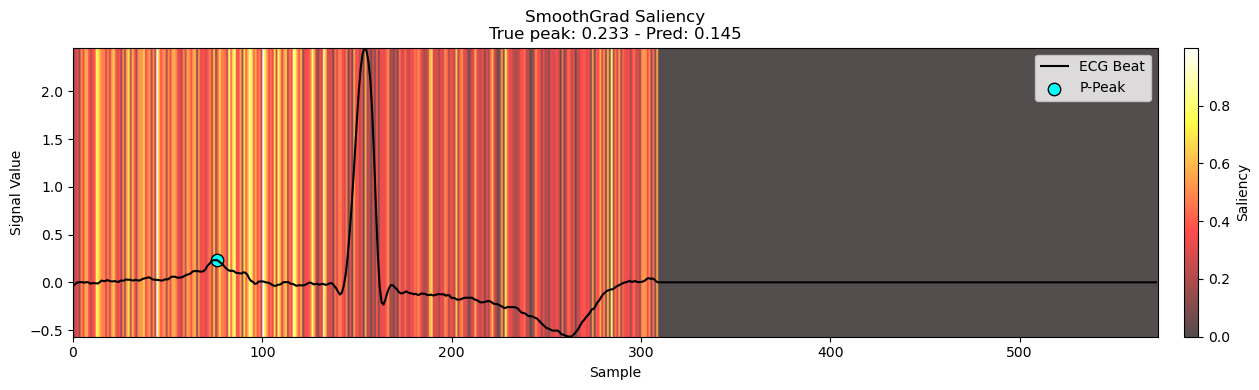

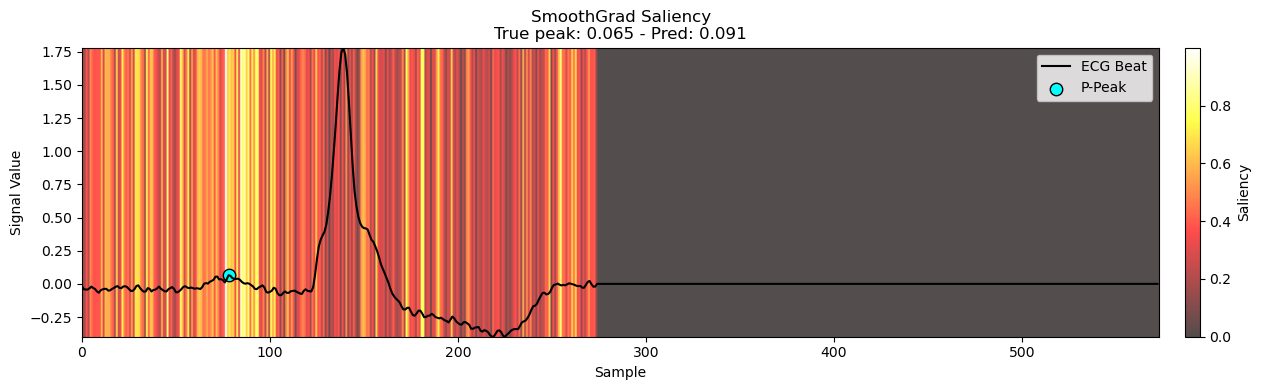

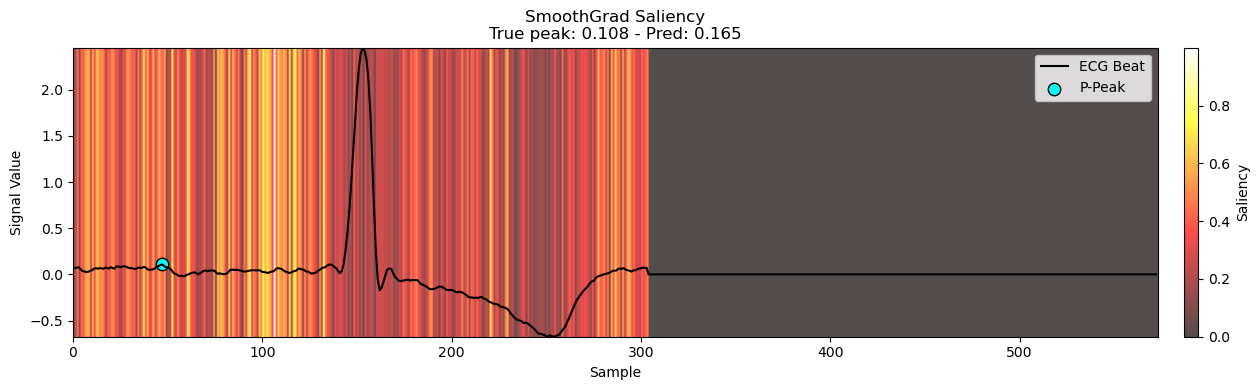

In [133]:
for i in range(len(samples)):
    beat = samples[i, :, 0]                    # ECG waveform
    smap_sg = sg_saliency_map[i]     # 1D saliency
    L = beat.shape[0]
    pks = peaks[i]                             # Indices of P-peaks for this beat
    label = labels[i]                          # True label
    pred = preds[i]                            # Predicted value

    fig, ax = plt.subplots(figsize=(14, 4))
    
    # Show the saliency as a background heatmap
    im0 = ax.imshow(
        np.vstack([smap_sg, smap_sg]), 
        cmap='hot', aspect='auto', alpha=0.7,
        extent=[0, L, beat.min(), beat.max()], origin='lower'
    )

    # Plot ECG waveform
    ax.plot(np.arange(L), beat, color='black', linewidth=1.5, label='ECG Beat')

    # Plot P-peaks
    ax.scatter(pks, beat[pks], c='cyan', edgecolors='k', s=80, label='P-Peak')

    ax.legend()
    ax.set_xlabel("Sample")
    ax.set_ylabel("Signal Value")
    ax.set_title(f"SmoothGrad Saliency\nTrue peak: {float(label):.3f} - Pred: {float(pred):.3f}")

    # Colorbar for the saliency
    cbar = fig.colorbar(im0, ax=ax, pad=0.02)
    cbar.set_label("Saliency")

    plt.tight_layout()
    plt.show()


/tmp/ipykernel_103/443855927.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)


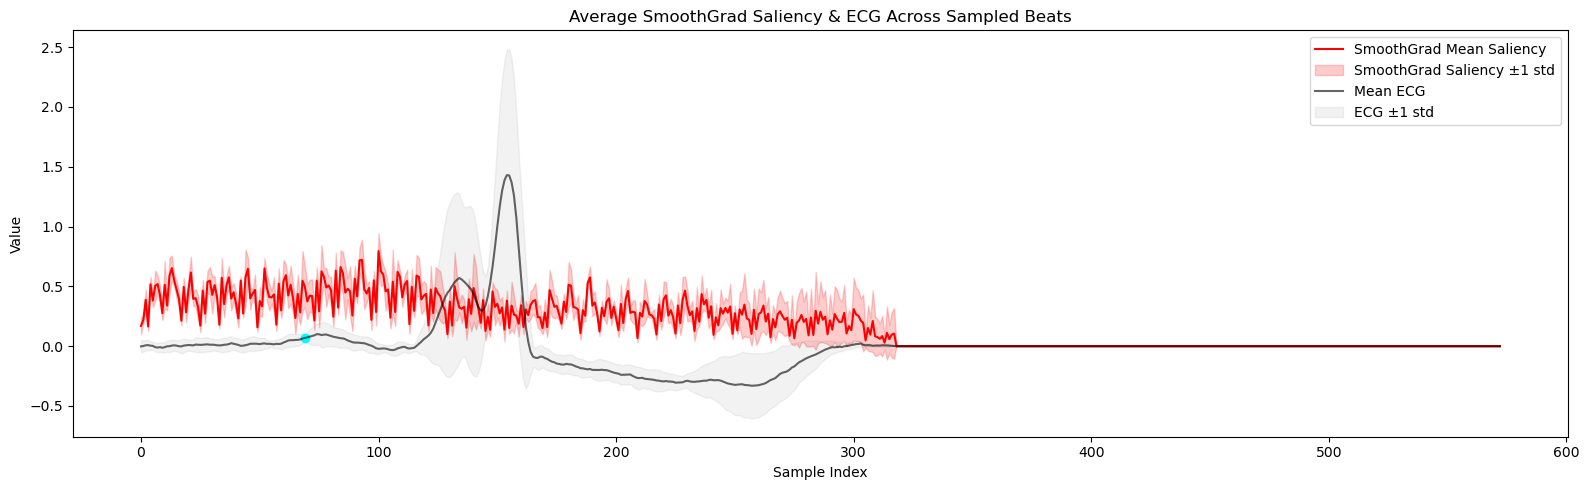

In [134]:
sg_mean_saliency = np.mean(sg_saliency_map, axis=0)
sg_std_saliency = np.std(sg_saliency_map, axis=0)

sg_mean_ecg = np.mean(samples[:, :, 0], axis=0)
sg_std_ecg = np.std(samples[:, :, 0], axis=0)

sg_mean_peaks = np.mean(peaks[:], axis = 0)

x = np.arange(sg_mean_saliency.shape[0])

plt.figure(figsize=(16, 5))
plt.plot(x, sg_mean_saliency, color='red', label='SmoothGrad Mean Saliency')
plt.fill_between(x,sg_mean_saliency - sg_std_saliency,sg_mean_saliency + sg_std_saliency,color='red', alpha=0.2, label='SmoothGrad Saliency ±1 std')

plt.plot(x, sg_mean_ecg, color='black', label='Mean ECG', alpha=0.6)
plt.fill_between(x, sg_mean_ecg - sg_std_ecg, sg_mean_ecg + sg_std_ecg,color='gray', alpha=0.1, label='ECG ±1 std')


plt.scatter(sg_mean_peaks, sg_mean_ecg[int(sg_mean_peaks)], color = 'cyan')

plt.title('Average SmoothGrad Saliency & ECG Across Sampled Beats')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.legend()
plt.tight_layout()
plt.show()


## Gradcam

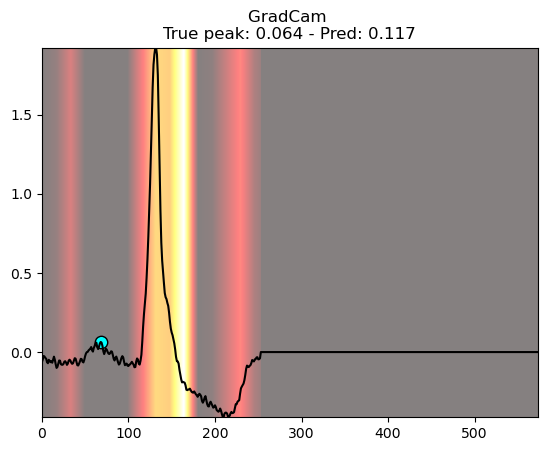

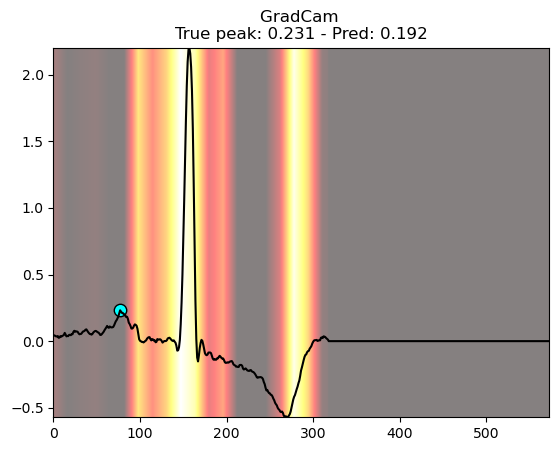

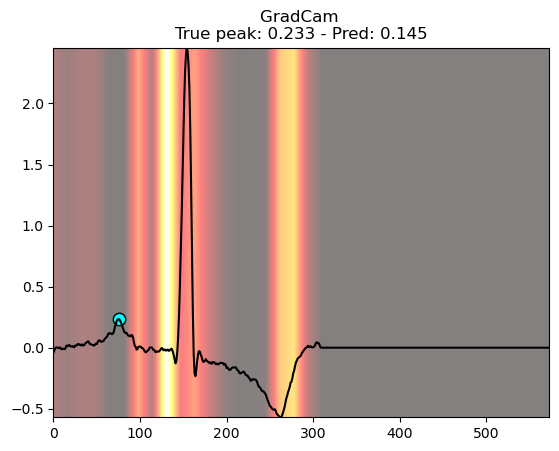

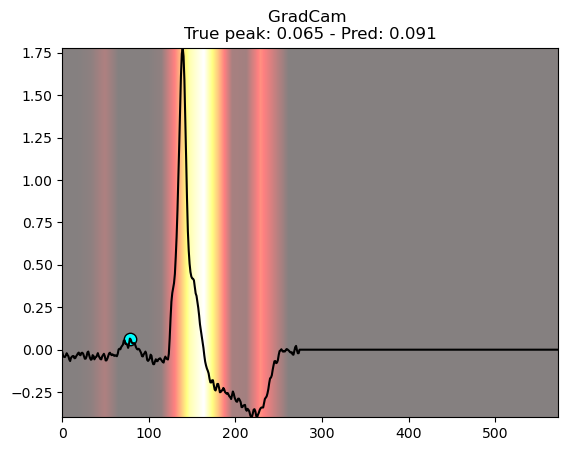

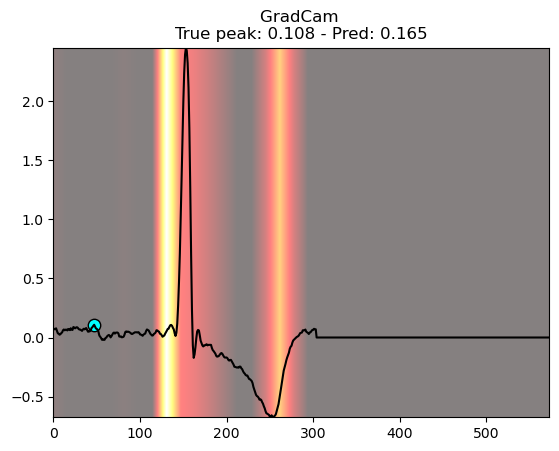

In [135]:
# Get the penultimate Conv1D layer (can use index or layer name)
penultimate_layer = 'conv1d_5'

# Create GradCAM object
gradcam = Gradcam(model, model_modifier=None, clone=True)

# Generate cam
cam = gradcam(score, samples, penultimate_layer=penultimate_layer)

# After computing sg_saliency_map
mask_cam = (samples != 0).astype(np.float32)  # 1 where real data, 0 where padding
mask_cam = np.squeeze(mask_cam, axis=-1)       # Remove channel dimension if present

cam = np.copy(cam)
cam[mask_cam == 0] = 0

# cam: (batch, steps), usually steps < input length
# Interpolate cam to match input length if needed:

cam_resized = np.array([
    scipy.ndimage.zoom(c, samples.shape[1] / c.shape[0], order=1)
    for c in cam
])

for i in range(len(samples)):
    plt.imshow(
    np.vstack([cam_resized[i], cam_resized[i]]), 
    cmap='hot', aspect='auto', alpha=0.5,
    extent=[0, samples.shape[1], samples[i, :, 0].min(), samples[i, :, 0].max()],
    origin='lower'
    )
    plt.plot(samples[i, :, 0], color='black', label='ECG')
    plt.scatter( peaks[i] , samples[i][peaks[i]], c='cyan', edgecolors='k', s=80, label='P-Peak')
    
    plt.title(f"GradCam \nTrue peak: {float(labels[i]):.3f} - Pred: {float(preds[i]):.3f}")
    
    plt.show()

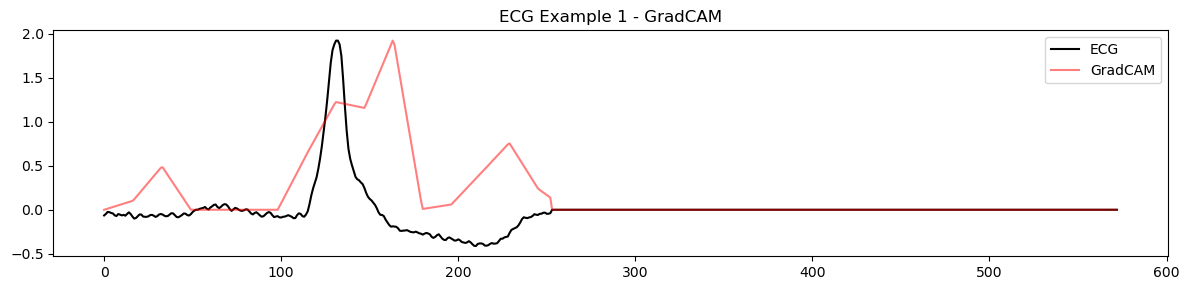

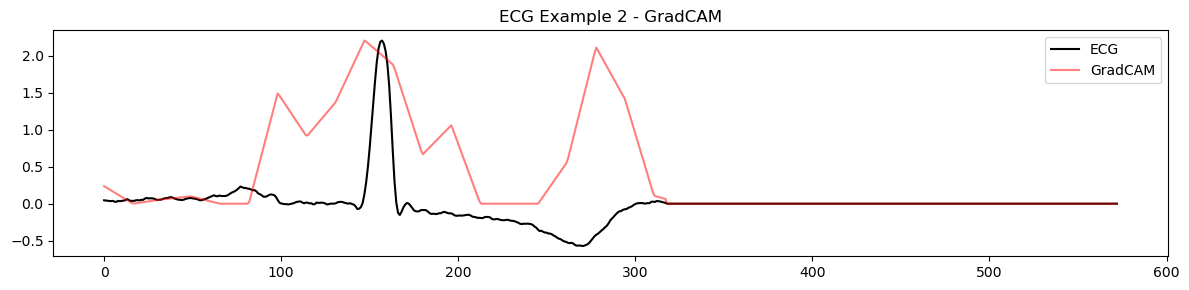

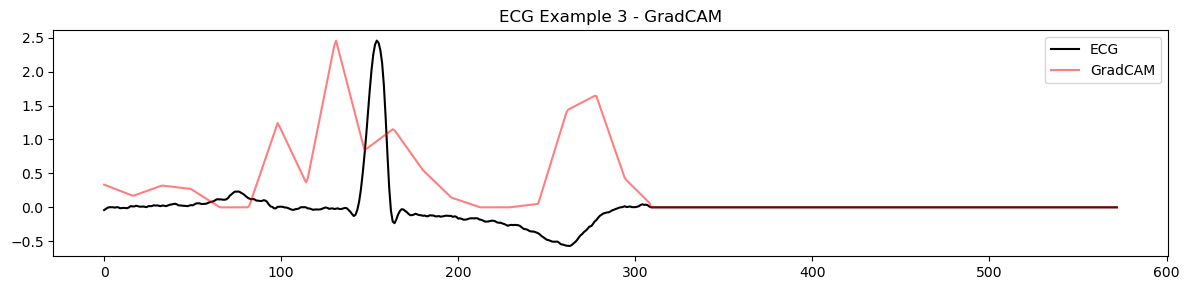

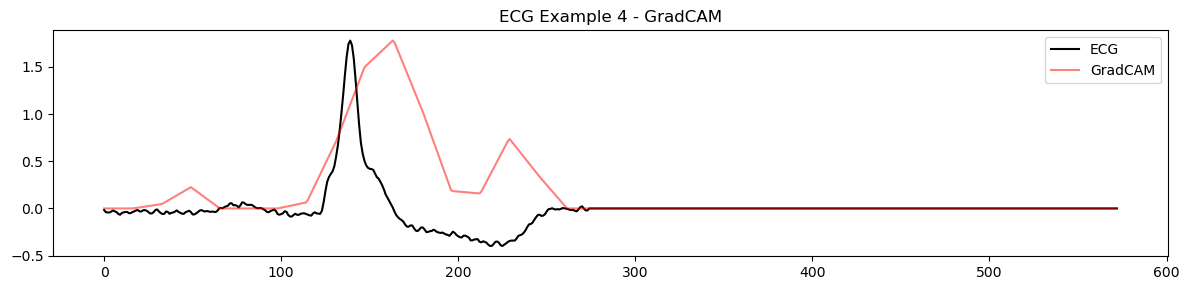

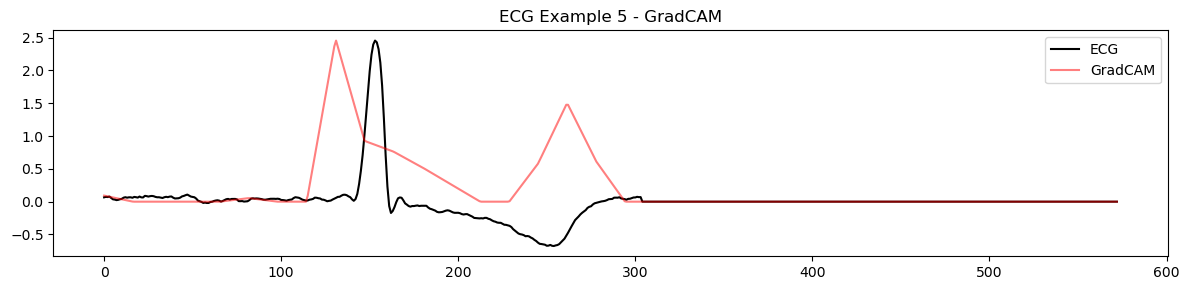

In [136]:
for i in range(len(samples)):
    plt.figure(figsize=(12, 3))
    plt.title(f"ECG Example {i+1} - GradCAM")
    plt.plot(samples[i, :, 0], color='black', label='ECG')
    plt.plot(cam_resized[i] / cam_resized[i].max() * samples[i, :, 0].max(),  # scale heatmap to waveform
             color='red', alpha=0.5, label='GradCAM')
    plt.legend()
    plt.tight_layout()
    plt.show()


## Gradcam plus plus

0.0 0.9999992


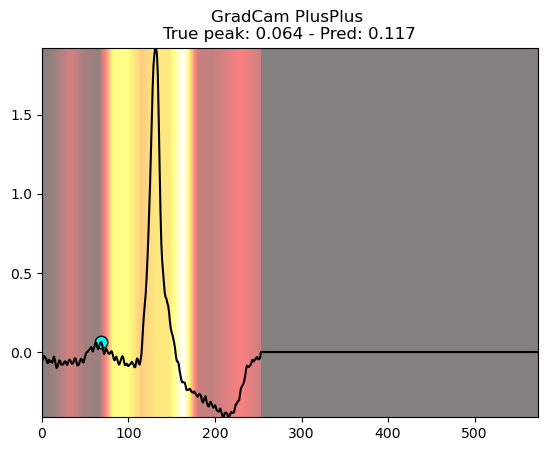

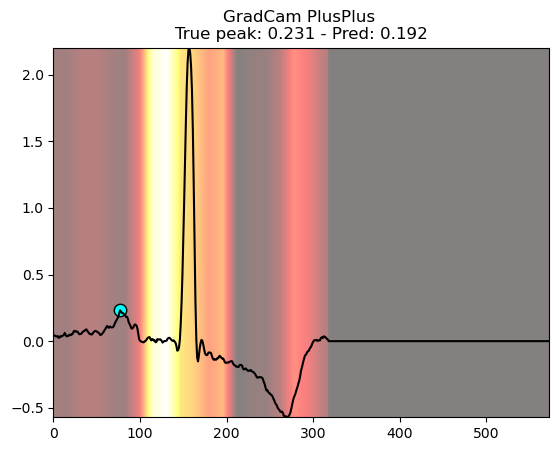

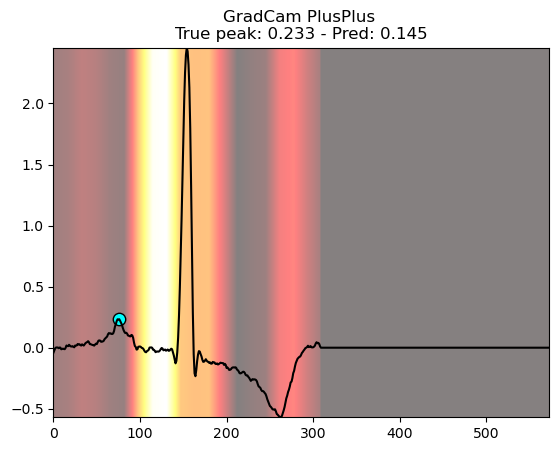

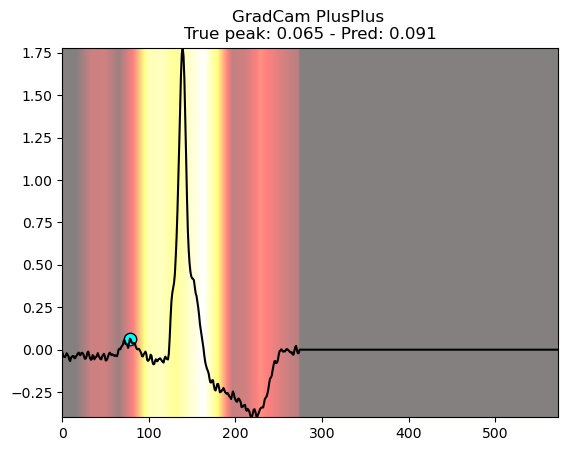

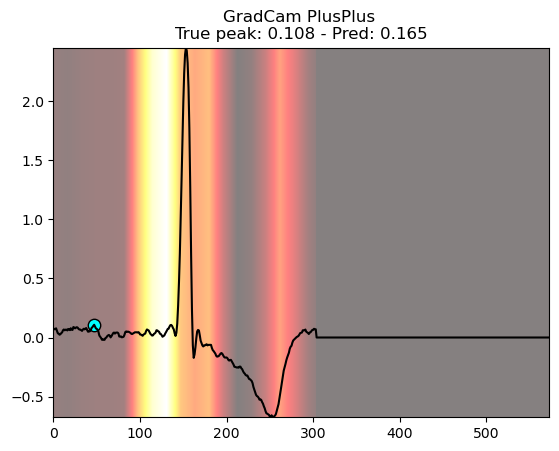

In [137]:
# Create GradCAM++ object
gradcam_plus = GradcamPlusPlus(model, model_modifier=None, clone=True)

# Generate heatmap with GradCAM++
cam_plus = gradcam_plus(score, samples, penultimate_layer =  penultimate_layer)

# After computing sg_saliency_map
mask_cam_plus = (samples != 0).astype(np.float32)  # 1 where real data, 0 where padding
mask_cam_plus = np.squeeze(mask_cam_plus, axis=-1)       # Remove channel dimension if present

cam_plus = np.copy(cam_plus)
cam_plus[mask_cam_plus == 0] = 0

# cam: (batch, steps), usually steps < input length
# Interpolate cam to match input length if needed:
import scipy.ndimage

cam_plus_resized = np.array([
    scipy.ndimage.zoom(c, samples.shape[1] / c.shape[0], order=1)
    for c in cam_plus
])
cam_plus_resized = np.array([
    scipy.ndimage.zoom(c, samples.shape[1] / c.shape[0], order=1)
    for c in cam_plus
])

print(np.nanmin(cam_plus_resized), np.nanmax(cam_plus_resized))
for i in range(len(samples)):
    plt.imshow(
    np.vstack([cam_plus_resized[i], cam_plus_resized[i]]), 
    cmap='hot', aspect='auto', alpha=0.5,
    extent=[0, samples.shape[1], samples[i, :, 0].min(), samples[i, :, 0].max()],
    origin='lower'
    )
    plt.plot(samples[i, :, 0], color='black', label='ECG')
    plt.scatter( peaks[i] , samples[i][peaks[i]], c='cyan', edgecolors='k', s=80, label='P-Peak')
    
    plt.title(f"GradCam PlusPlus \nTrue peak: {float(labels[i]):.3f} - Pred: {float(preds[i]):.3f}")
    
    plt.show()

## Score cam

40/40 [==============================] - 0s 1ms/step


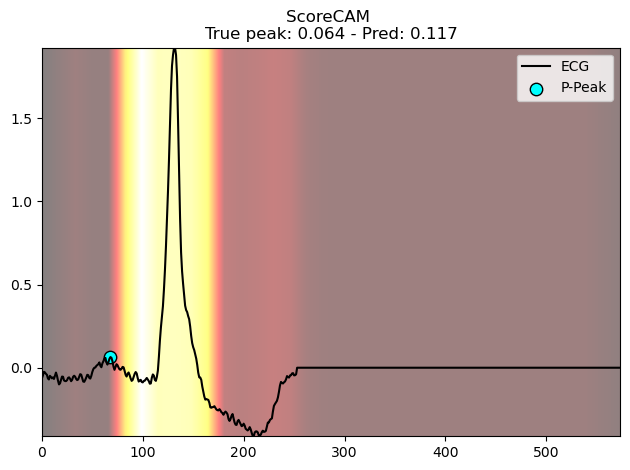

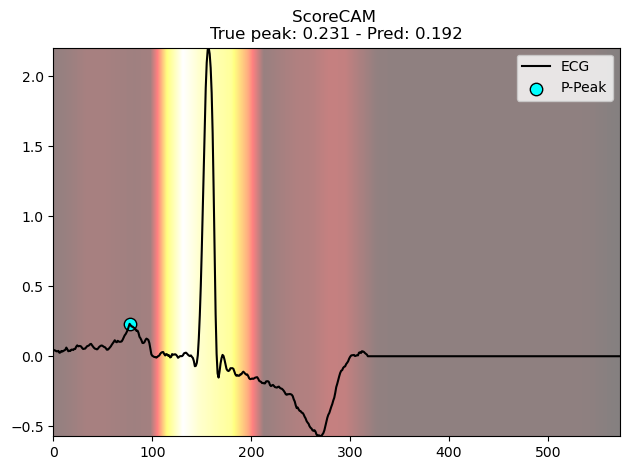

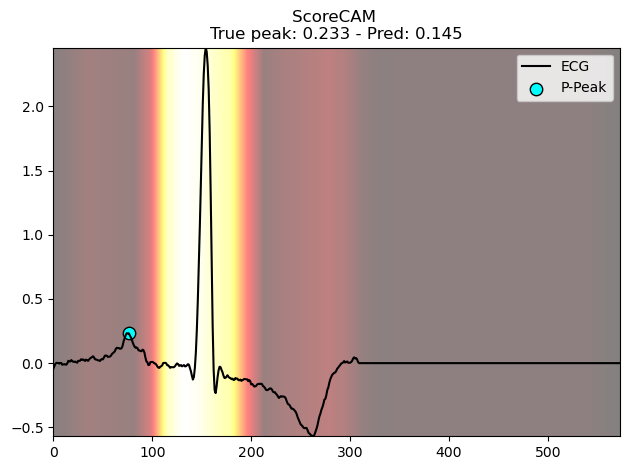

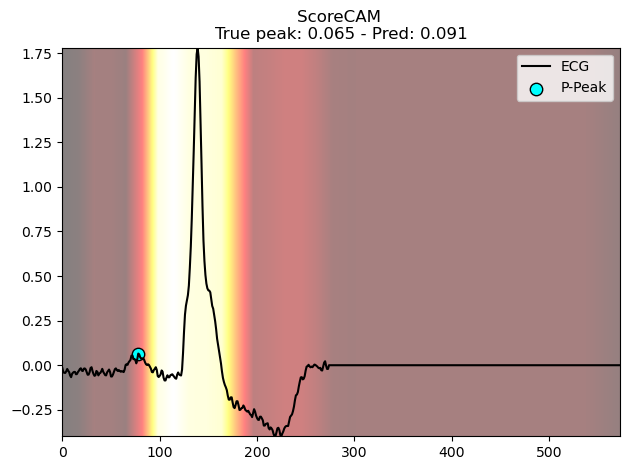

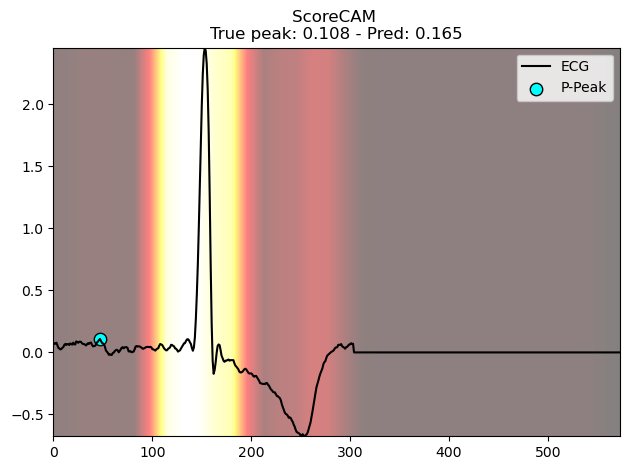

In [138]:
# Create ScoreCAM object
scorecam = Scorecam(model)

# Generate heatmap with ScoreCAM
cam = scorecam(score, samples, penultimate_layer= penultimate_layer)

cam_resized = np.array([
    scipy.ndimage.zoom(c, samples.shape[1] / c.shape[0], order=1)
    for c in cam
])

for i in range(len(samples)):
    plt.imshow(
        np.vstack([cam_resized[i], cam_resized[i]]), 
        cmap='hot', aspect='auto', alpha=0.5,
        extent=[0, samples.shape[1], samples[i, :, 0].min(), samples[i, :, 0].max()],
        origin='lower'
    )
    plt.plot(samples[i, :, 0], color='black', label='ECG')
    plt.scatter( peaks[i] , samples[i][peaks[i]], c='cyan', edgecolors='k', s=80, label='P-Peak')

    plt.title(f"ScoreCAM \nTrue peak: {float(labels[i]):.3f} - Pred: {float(preds[i]):.3f}")
    plt.legend()
    plt.tight_layout()
    plt.show()

## Faster Score CAM

3/3 [==============================] - 0s 97ms/step


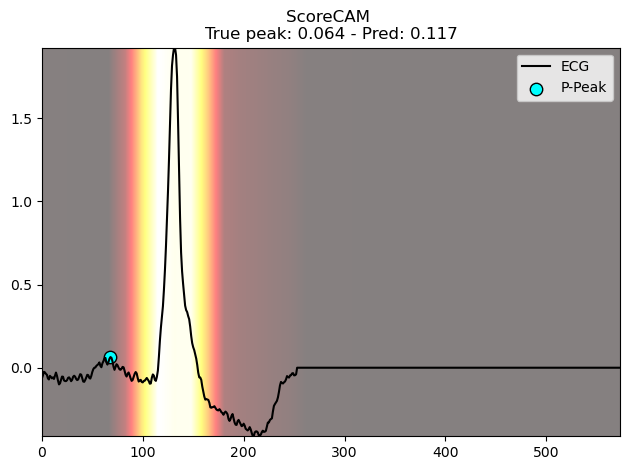

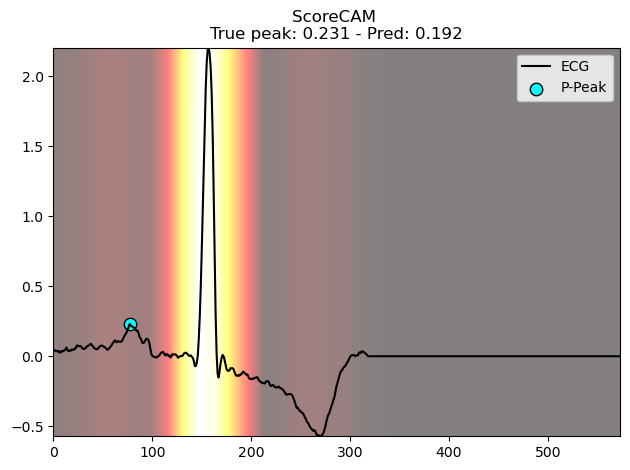

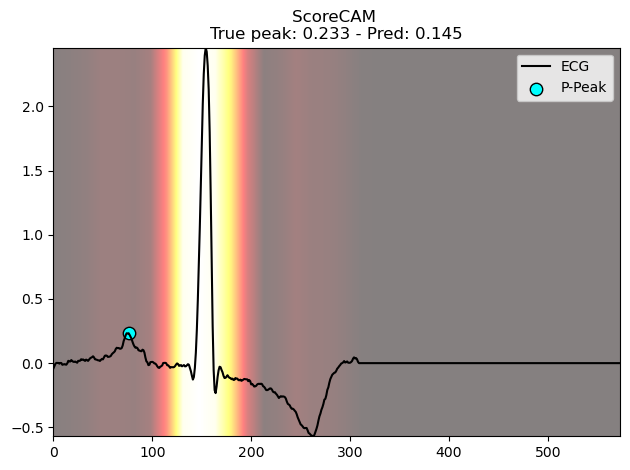

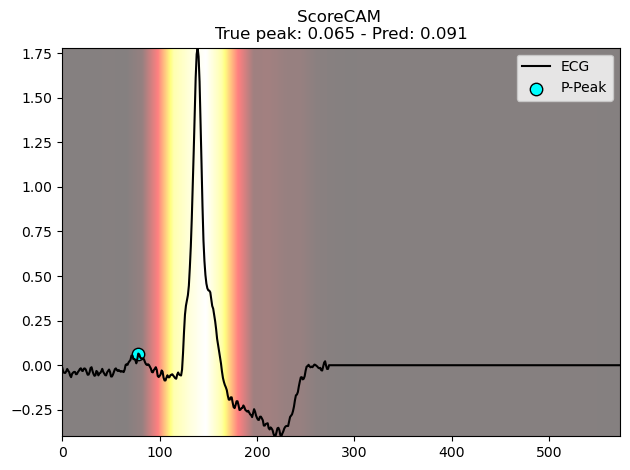

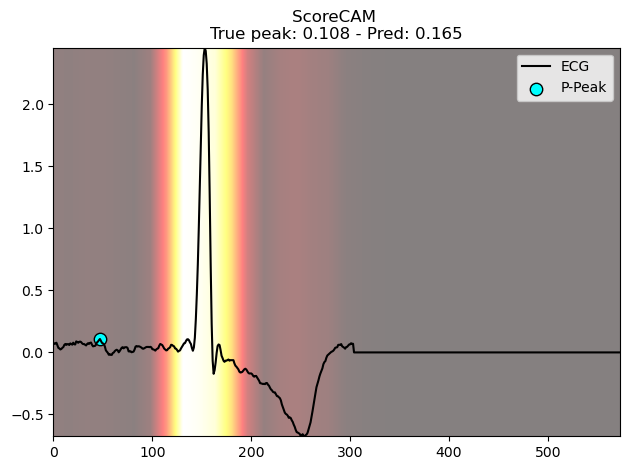

In [139]:
# Create ScoreCAM object
scorecam = Scorecam(model)

# Generate heatmap with ScoreCAM
cam = scorecam(score, samples, penultimate_layer= penultimate_layer,  max_N=10)

cam_resized = np.array([
    scipy.ndimage.zoom(c, samples.shape[1] / c.shape[0], order=1)
    for c in cam
])

for i in range(len(samples)):
    plt.imshow(
        np.vstack([cam_resized[i], cam_resized[i]]), 
        cmap='hot', aspect='auto', alpha=0.5,
        extent=[0, samples.shape[1], samples[i, :, 0].min(), samples[i, :, 0].max()],
        origin='lower'
    )
    plt.plot(samples[i, :, 0], color='black', label='ECG')
    plt.scatter( peaks[i] , samples[i][peaks[i]], c='cyan', edgecolors='k', s=80, label='P-Peak')

    plt.title(f"ScoreCAM \nTrue peak: {float(labels[i]):.3f} - Pred: {float(preds[i]):.3f}")
    plt.legend()
    plt.tight_layout()
    plt.show()

## Guided backpropagation

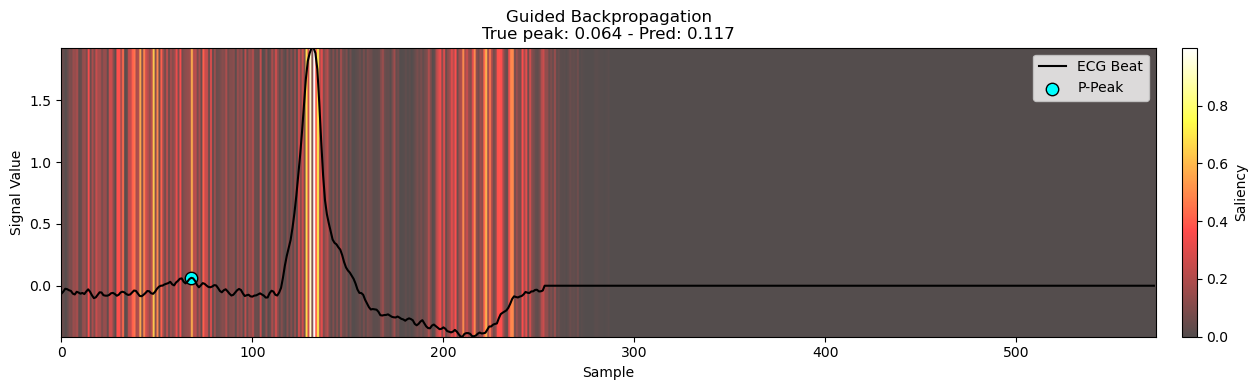

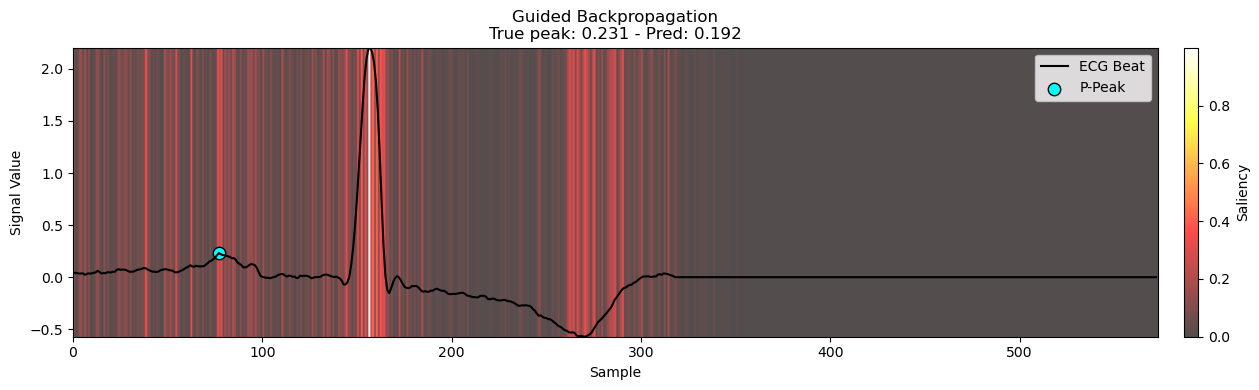

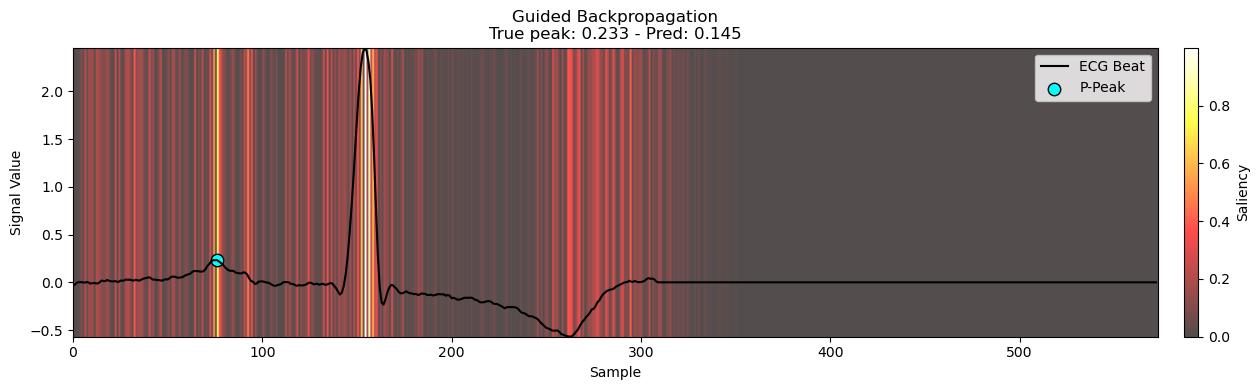

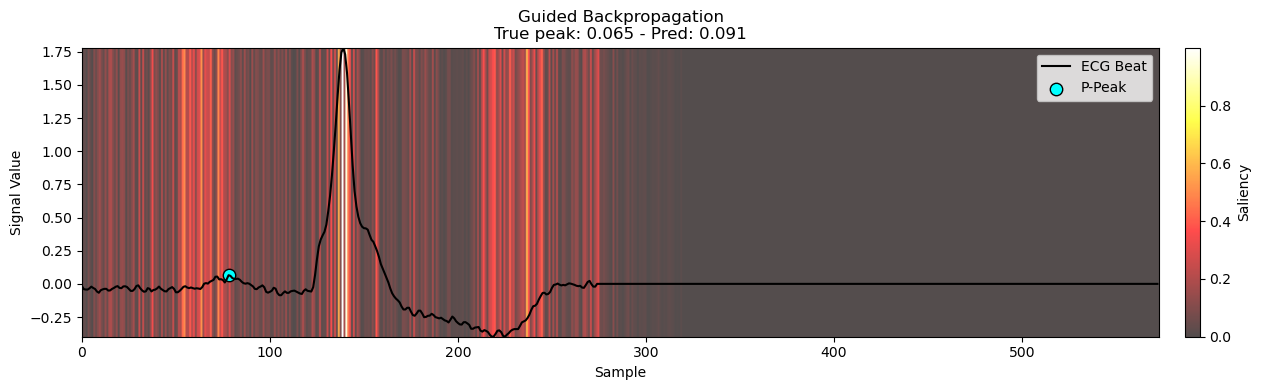

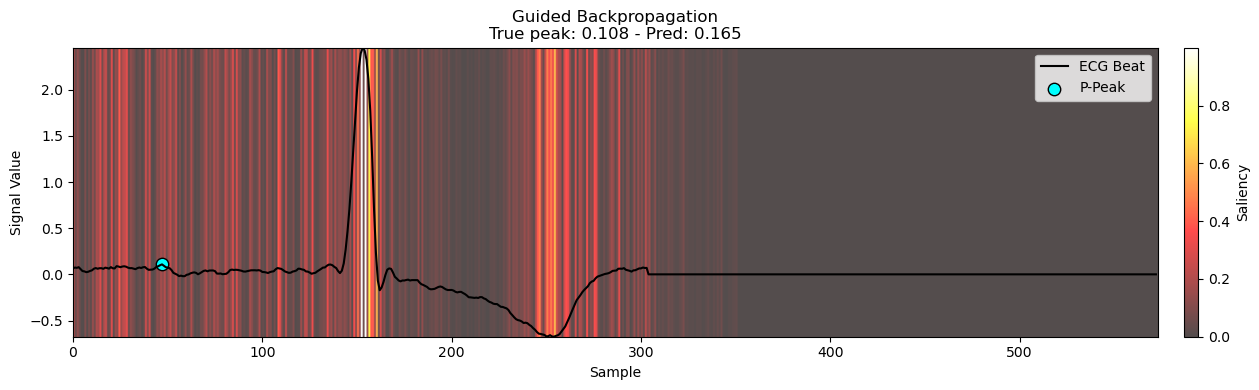

In [140]:
gb_saliency = Saliency(model, model_modifier=GuidedBackpropagation(), clone=True)
gb_saliency_map = gb_saliency(score, samples)

for i in range(len(samples)):
    beat = samples[i, :, 0]                    # ECG waveform
    smap_gb = gb_saliency_map[i]     # 1D saliency
    L = beat.shape[0]
    pks = peaks[i]                             # Indices of P-peaks for this beat
    label = labels[i]                          # True label
    pred = preds[i]                            # Predicted value

    fig, ax = plt.subplots(figsize=(14, 4))
    
    im0 = ax.imshow(
        np.vstack([smap_gb, smap_gb]), 
        cmap='hot', aspect='auto', alpha=0.7,
        extent=[0, L, beat.min(), beat.max()], origin='lower'
    )

    # Plot ECG waveform
    ax.plot(np.arange(L), beat, color='black', linewidth=1.5, label='ECG Beat')

    # Plot P-peaks
    ax.scatter(pks, beat[pks], c='cyan', edgecolors='k', s=80, label='P-Peak')

    ax.legend()
    ax.set_xlabel("Sample")
    ax.set_ylabel("Signal Value")
    ax.set_title(f"Guided Backpropagation\nTrue peak: {float(label):.3f} - Pred: {float(pred):.3f}")

    # Colorbar for the saliency
    cbar = fig.colorbar(im0, ax=ax, pad=0.02)
    cbar.set_label("Saliency")

    plt.tight_layout()
    plt.show()


/tmp/ipykernel_103/1794481681.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)


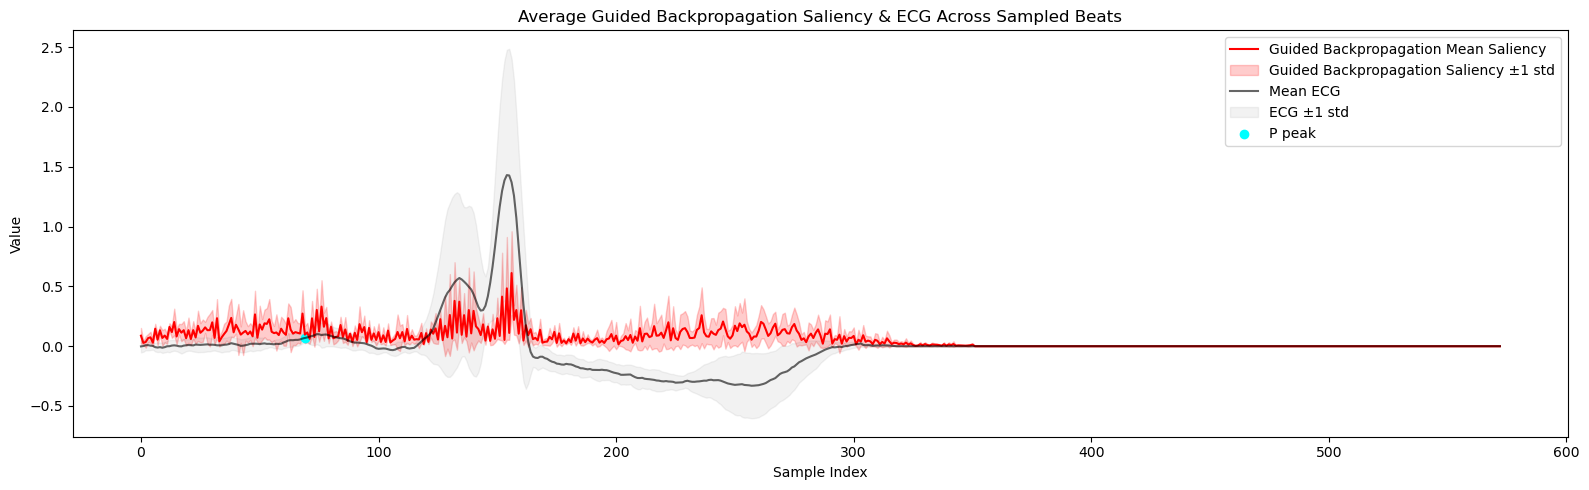

In [141]:
gb_mean_saliency = np.mean(gb_saliency_map, axis=0)
gb_std_saliency = np.std(gb_saliency_map, axis=0)

gb_mean_ecg = np.mean(samples[:, :, 0], axis=0)
gb_std_ecg = np.std(samples[:, :, 0], axis=0)

gb_mean_peaks = np.mean(peaks[:], axis = 0)

x = np.arange(gb_mean_saliency.shape[0])

plt.figure(figsize=(16, 5))
plt.plot(x, gb_mean_saliency, color='red', label='Guided Backpropagation Mean Saliency')
plt.fill_between(x,gb_mean_saliency - gb_std_saliency,gb_mean_saliency + gb_std_saliency,color='red', alpha=0.2, label='Guided Backpropagation Saliency ±1 std')

plt.plot(x, gb_mean_ecg, color='black', label='Mean ECG', alpha=0.6)
plt.fill_between(x, gb_mean_ecg - gb_std_ecg, gb_mean_ecg + gb_std_ecg,color='gray', alpha=0.1, label='ECG ±1 std')


plt.scatter(gb_mean_peaks, gb_mean_ecg[int(gb_mean_peaks)], color = 'cyan', label = 'P peak')

plt.title('Average Guided Backpropagation Saliency & ECG Across Sampled Beats')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.legend()
plt.tight_layout()
plt.show()


## Guided Grad Cam

In [142]:
guided_gradcam = gb_saliency_map * cam_resized  

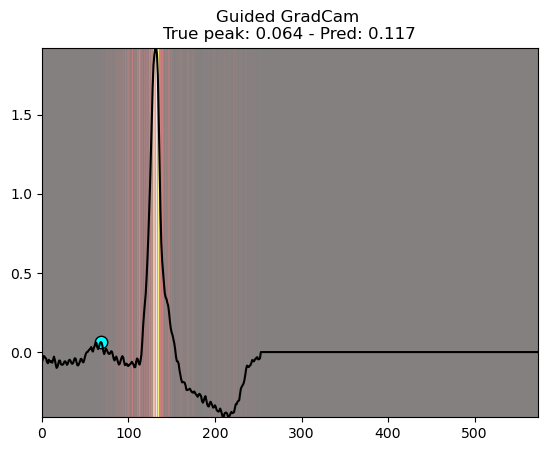

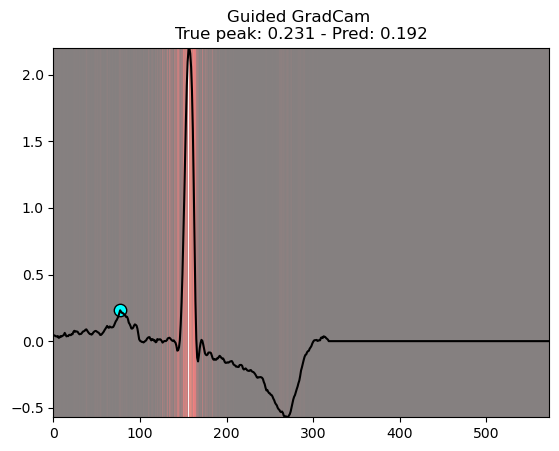

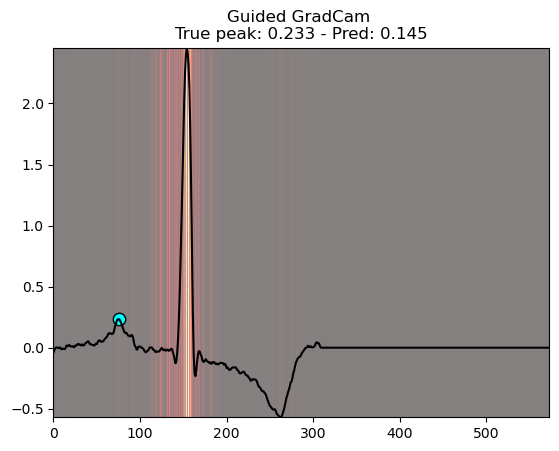

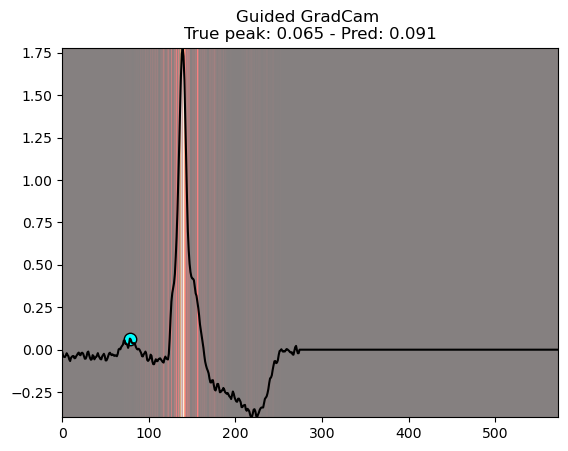

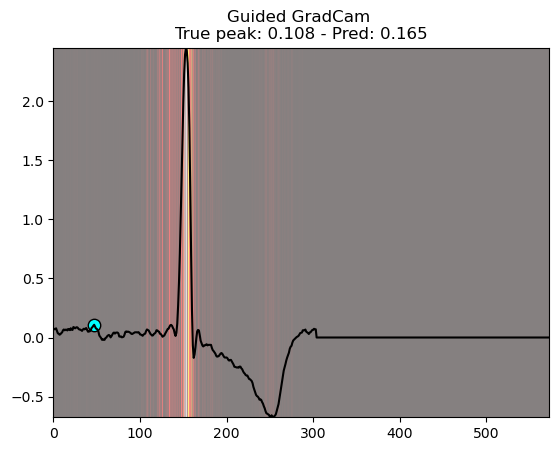

In [143]:
for i in range(len(samples)):
    plt.imshow(
    np.vstack([guided_gradcam[i], guided_gradcam[i]]), 
    cmap='hot', aspect='auto', alpha=0.5,
    extent=[0, samples.shape[1], samples[i, :, 0].min(), samples[i, :, 0].max()],
    origin='lower'
    )
    plt.plot(samples[i, :, 0], color='black', label='ECG')
    plt.scatter( peaks[i] , samples[i][peaks[i]], c='cyan', edgecolors='k', s=80, label='P-Peak')
    
    plt.title(f"Guided GradCam \nTrue peak: {float(labels[i]):.3f} - Pred: {float(preds[i]):.3f}")
    
    plt.show()

# Visualising Conv filters

## a filter

In [165]:
from tf_keras_vis.utils.model_modifiers import ExtractIntermediateLayer, ReplaceToLinear
from tf_keras_vis.activation_maximization import ActivationMaximization
from tf_keras_vis.activation_maximization.callbacks import Progress
from tf_keras_vis.activation_maximization.regularizers import Norm, Regularizer
from tf_keras_vis.activation_maximization.input_modifiers import Jitter

200/200 [==============================] - 4s 18ms/step - Score: -10.1322 - Norm: 31.0696


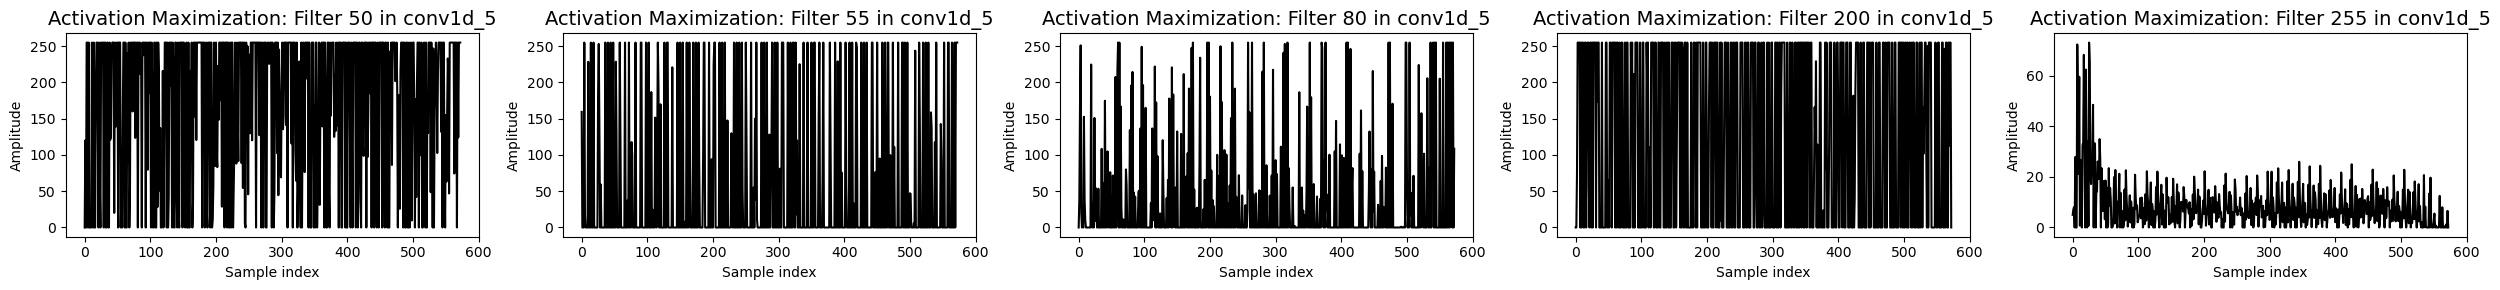

In [146]:
layer_name = 'conv1d_5' #target layer

#new model whose output is replaced to `block5_conv3` layer's output
extract_intermediate_layer = ExtractIntermediateLayer(index_or_name=layer_name)
#modify the model's last activation function to linear
replace2linear = ReplaceToLinear()

activation_maximization = ActivationMaximization(
    model,
    model_modifier=[extract_intermediate_layer, replace2linear],
    clone=False)

seq_len = samples.shape[1]
seed_input = np.random.normal(size=(1, seq_len, 1)).astype(np.float32)

filter_numbers = [50,55,80,200,255]
nrows = 1
ncols = len(filter_numbers)

fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*5, nrows*3))

for idx, i in enumerate(filter_numbers):
    def score_am(output):
        return tf.reduce_mean(output[:, :, i])

    # Generate maximized activation
    activations = activation_maximization(score_am, seed_input=seed_input, input_modifiers=[], regularizers=[Norm(2)], callbacks=[Progress()])
    activations = activations.numpy()

    ax = axes[idx] if nrows == 1 else axes[idx // ncols, idx % ncols]
    ax.plot(activations[0].squeeze(), color='black')
    ax.set_title(f'Activation Maximization: Filter {i} in {layer_name}', fontsize=14)
    ax.set_xlabel("Sample index")
    ax.set_ylabel("Amplitude")
plt.tight_layout()
plt.show()

# visualizing dense layer

200/200 [==============================] - 6s 27ms/step - Score: 18755.5703 - Norm: 789.3600


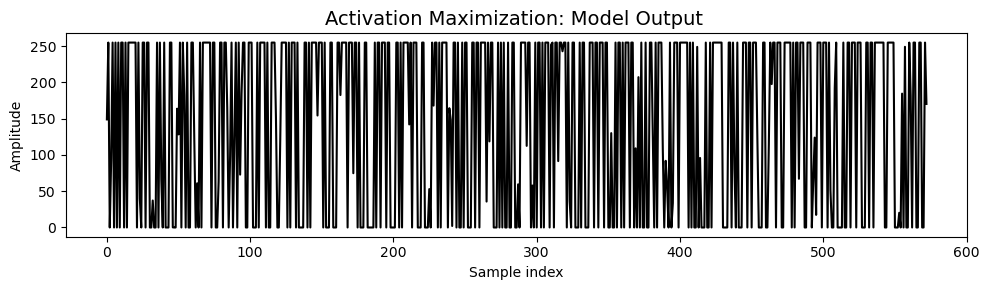

In [173]:
def score_function(output):
    return output[:, 0]
    
activation_maximization = ActivationMaximization(model, model_modifier = None, clone=True)

seq_len = samples.shape[1]
seed_input = np.random.normal(size=(1, seq_len, 1)).astype(np.float32)

# Generate maximized activation
activations = activation_maximization(score_function, seed_input=seed_input, input_modifiers=[], regularizers=[Norm(2)], callbacks=[Progress()])
activations = activations.numpy()

plt.figure(figsize=(10, 3))
plt.plot(activations[0].squeeze(), color='black')
plt.title(f'Activation Maximization: Model Output ', fontsize=14)
plt.xlabel("Sample index")
plt.ylabel("Amplitude")
plt.tight_layout()
plt.show()